<a href="https://www.kaggle.com/code/calistusmwonga/cnn-tree-markdowns-version?scriptVersionId=255482585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/calistusmwonga/cnn-xgbm-sotr-efficientnetv2b0173ef58638?scriptVersionId=254960407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **CLASSIFICATION FOR LANDSLIDE DETECTION**


# 1. **Business Understanding**

## 1.1 Problem Statement

- Landslides are critical natural hazards, often triggered by extreme weather and seismic events. The impact on human lives, property, and infrastructure is significant, making rapid and accurate detection essential for effective disaster management and climate resilience planning.
- Traditional monitoring methods relying solely on optical satellite imagery often fail due to persistent cloud cover, which is frequently present during the storm events that trigger landslides. This delay in detection creates a critical information gap, That hampers risk assessment when they are needed most. There is a clear business need for a reliable detection system that functions under all weather conditions, especially in remote or inaccessible regions.

## 1.2 Project Aim:
- The aim of this project is to develop an AI-based system for detecting and classifying landslides using satellite and radar imagery. This system will support disaster management agencies by providing timely and reliable detection, and will assist geospatial researchers in understanding patterns and impacts of landslide events.

## 1.3 Project Objectives
To address this problem, this project will deliver an AI system with the following primary objectives:
1. To build and evaluate a machine learning model capable of accurately classifying landslide events by synergistically using both all-weather Synthetic Aperture Radar (SAR) data and traditional optical satellite imagery.
2. To perform domain-specific feature engineering by testing out various engineered features to determine whether they offer a stronger predictive signal than the raw spatial patterns alone.  
3. To implement Explainable AI (XAI) techniques using SHARP on the most successful model. This is to prevent developing a black-box model and instead provide a clear understanding into how the model came to it's coLnclusion by understanding which features are driving the detection of a landslide which makes it trustworthy for stakeholders



# 2. Data Understanding

## **2.1 Data Source** 
The dataset for this challenge is from https://zindi.africa/competitions/classification-for-landslide-detection/data 
- It contains multi-modal collection, combining satellite imagery from two distinct sources to provide a comprehensive view of ground conditions.
  
**These two types of data are:**
1. *Optical Imagery (Sentinel-2)*: This data is sourced from the Sentinel-2 MultiSpectral Instrument (MSI). It provides high-resolution (10m) Red, Green, Blue, and Near-Infrared (NIR) bands. While it is highly interpretable, optical data is susceptible to obstruction by cloud cover.
2. *Radar Imagery (Sentinel-1):* This data provides all-weather imaging capabilities, which is crucial for monitoring events in cloud-covered regions. It includes Synthetic Aperture Radar (SAR) data with VV (Vertical-Vertical) and VH (Vertical-Horizontal) polarizations, also at a 10m resolution.

#### The files provided for this project are as follows:
| **File Name**                      | **Description**                                                                                         |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------- |
| `Train.csv` / `Test.csv`           | Metadata files containing the image IDs and, for the training set, the target label (1 for landslide).  |
| `train_data.zip` / `test_data.zip` | Contains the multi-band image data as individual `.npy` files, corresponding to the IDs in the CSVs.    |
| `Trustworthiness Evaluation.pdf`   | A document outlining the criteria for building trustworthy and ethical AI solutions for this challenge. |


## 2.2 Data Description and Attributes
Each .npy file contains a 12-channel image array. These bands, represent a fusion of optical and radar data captured post-event, along with pre-calculated change detection bands.

Band Breakdown: <br>
 **Optical Bands (Sentinel-2):** These provide visual information about the landscape.
- Band 1: Red
- Band 2: Green
- Band 3: Blue
- Band 4: Near-Infrared (NIR) <br>
**SAR Bands - Descending Orbit (Sentinel-1):** Radar data from the satellite's descending pass.
- Band 5: VV Polarization (Post-Event)
- Band 6: VH Polarization (Post-Event)
- Band 7: VV Change Detection (Difference)
- Band 8: VH Change Detection (Difference) <br>
**SAR Bands - Ascending Orbit (Sentinel-1):** Radar data from the satellite's ascending pass.
- Band 9: VV Polarization (Post-Event)
- Band 10: VH Polarization (Post-Event)
- Band 11: VV Change Detection (Difference)
- Band 12: VH Change Detection (Difference)

# Import Libraries

In [1]:
# Core Libraries 
import os
import random
import time 
import traceback
import logging
import warnings

# For data manipulation and analysis
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# For statistical feature engineering
from scipy.stats import kurtosis, skew

# For scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosted Models
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Fo Hyperparameter Tuning
import optuna

# For Model Interpretability
import shap

# For  TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetV2B0 # and others
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet_v2, resnet_v2, densenet # Import preprocessing functions
      

print("Libraries imported successfully. ")  

2025-08-11 17:21:10.913889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754932871.108982      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754932871.161763      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully. 


## Initial Data Exploration



## Global Configuration
- This section sets up the global environment, including the distribution strategy for multi-GPU training.
- This block gathers all the key parameters from across your notebook into one convenient place.

In [2]:
# CONFIGURATION & SETUP

class Config:
    
    USE_CROSS_VALIDATION = False 
    USE_FULL_DATASET = False
    USE_MULTI_GPU = True
    ENABLE_FINE_TUNING = True
    SAMPLE_FRACTION = 0.50 
    MODEL_FAMILY = 'EfficientNetV2B0' # model architecture to use
    BATCH_SIZE = 128
    IMAGE_SIZE = (64, 64) 
    TARGET_SIZE = (224, 224)
    N_CHANNELS = 15

    #  TRAINING HYPERPARAMETERS 
    EPOCHS_PHASE_1 = 80
    EPOCHS_PHASE_2 = 50
    LEARNING_RATE_PHASE_1 = 1e-3 #1e-4 #1e-3  #5e-4
    LEARNING_RATE_PHASE_2 = 3e-5

    # MODEL & LOSS HYPERPARAMETERS 
    DROPOUT_RATE = 0.4
    CLIPNORM_VALUE = 1.0 # gradient clipping to prevent exploding gradients
    FOCAL_LOSS_ALPHA = 0.75 #(balances positive/negative importance).
    FOCAL_LOSS_GAMMA = 2.0  # focuses on hard examples
    # ReduceLROnPlateau settings
    PATIENCE = 3
    FACTOR = 0.2
    MIN_LR = 1e-6
   
    # The global random seed for all operations.
    SEED = 42
    N_FOLDS = 3 
    SAVE_MODELS_PER_FOLD = True

print("Configuration Class Defined")
print(f"Batch size set to: {Config.BATCH_SIZE}")
print(f"Using full dataset: {Config.USE_FULL_DATASET}")

Configuration Class Defined
Batch size set to: 128
Using full dataset: False


# 3. Create the Global Setup Cell (Seeds & Strategy)
This cell will perform two critical setup tasks:

1. It will set all the random seeds using the SEED from our Config class to ensure our experiments are reproducible.
2. It will read the USE_MULTI_GPU flag from our Config class and initialize the correct TensorFlow distribution strategy (MirroredStrategy for two GPUs, or a default strategy for one).

In [3]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY
def set_seeds(seed=Config.SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"--- Global random seed set to {seed} ---")

set_seeds()


# initialize the distribution strategy
if Config.USE_MULTI_GPU:
    
    strategy = tf.distribute.MirroredStrategy()
    print("--- MirroredStrategy activated for Multi-GPU training. ---")
else:
    # When not using multiple GPUs
    strategy = tf.distribute.get_strategy()
    print("--- Default strategy activated for Single-GPU/CPU training. ---")

print(f"Number of replicas (GPUs) in sync: {strategy.num_replicas_in_sync}")


# Suppress TensorFlow AutoGraph, Keras, Numpy  warnings 
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="keras.src.callbacks.reduce_lr_on_plateau")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.saving.saving_lib")


print("\n--- Annoying warnings have been silenced for a cleaner training log. ---")

--- Global random seed set to 42 ---
--- MirroredStrategy activated for Multi-GPU training. ---
Number of replicas (GPUs) in sync: 1

--- Annoying warnings have been silenced for a cleaner training log. ---


I0000 00:00:1754932882.527308      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Data Preparation & Pipeline
This section handles all data loading, splitting, and the creation of a high-performance `tf.data` pipeline for feeding the model.

# 4. Define Data Paths & Load Initial DataFrames
Set up the file paths and load the metadata from the Train.csv and Test.csv files.

In [4]:
# DATA PREPARATION & PIPELINE

# Original Data Path for CSVs
ORIGINAL_DATA_PATH = "/kaggle/input/landslide-detection"
TRAIN_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Train.csv')
TEST_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Test.csv')
TRAIN_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'train_data/train_data')
TEST_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'test_data/test_data')

# TFRecord Data Path 
TFRECORD_DATA_PATH = "/kaggle/input/landslide-data-tfrecords1/tfrecords"
TRAIN_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'train.tfrecord')
TEST_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'test.tfrecord')

# Load the full training dataframe 
full_train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

print(f"Full training dataset has {len(full_train_df)} samples.")
print(f"Test dataset has {len(test_df)} samples.")
print(f"Train TFRecord path: {TRAIN_TFRECORD_PATH}")
print("-" * 30)


# A temporary dataframe `df` to hold either the full data or a sample.
if Config.USE_FULL_DATASET:
    print("Using FULL dataset for K-Fold splitting.")
    df = full_train_df.copy()
else:
    # For sample create a stratified subsample.
    print(f"Using {Config.SAMPLE_FRACTION * 100}% subsample for K-Fold splitting.")
    _, df = train_test_split(
        full_train_df,
        test_size=Config.SAMPLE_FRACTION,
        stratify=full_train_df['label'],
        random_state=Config.SEED
    )
    
print(f"DataFrame for splitting has {len(df)} samples.")
print("-" * 30)

# Define paths to the .npy file folders 


print(f".npy Training data path: {TRAIN_NPY_PATH}")
print(f".npy Test data path: {TEST_NPY_PATH}")



Full training dataset has 7147 samples.
Test dataset has 5398 samples.
Train TFRecord path: /kaggle/input/landslide-data-tfrecords1/tfrecords/train.tfrecord
------------------------------
Using 50.0% subsample for K-Fold splitting.
DataFrame for splitting has 3574 samples.
------------------------------
.npy Training data path: /kaggle/input/landslide-detection/train_data/train_data
.npy Test data path: /kaggle/input/landslide-detection/test_data/test_data


### Check the percentage and visualize the distribution

In [5]:
# check for imbalance in the dataset and return as a percentage
full_train_df.label.value_counts(normalize=True)*100

label
0    82.440185
1    17.559815
Name: proportion, dtype: float64

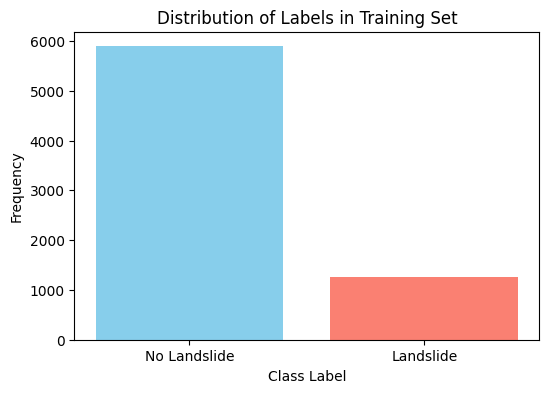

In [6]:
# Check distribution of labels
label_counts = full_train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

### **Observation** <br>
The bar chart clearly shows that there is a significant class imbalance in the training data.
- The `No Landslide` (0) is the majority class with a frequency of about 6,000
- The `landslide` (1) is the minority class with a frequency of aproximately 1,200

### **IMPLICATIONS FOR THIS PROJECT**
- Due to the class imbalance using accuracy as a fundamental evaluation metric will lead to a flaw in our evaluation.This is cause a model can achieve over 80% accuracy while just always predicted "No Landslide".
- Therefore, the primary success metric for this project is the **F1-Score** as it measures the model's performance on the minority class  by forcing a balance between precision an recall. Thus a high F1-Score is only achievable by a model that skillfully handles this trade-off <br>

 **Techniques used.** <br>
To ensure the model learns the patterns of the minority class the following techniques were implemented:
- **Focal Loss function**- It dynamically adjusts the weight of each sample, forcing the model to focus its learning efforts on the "**hard**," misclassified examples, which are overwhelmingly part of the minority "Landslide" class. This prevents the easy majority class samples from dominating the training process.
- **Stratified K-Fold Cross-Validation**- It preserves the class distribution ratio within each fold, guaranteeing that every validation split is a representative sample of the overall dataset. This makes our final averaged OOF (Out-of-Fold) score a much more trustworthy measure of true model performance.
- **Oversampling of minority class** - The model will be feed batches with a 50/50 split of "Landslide" and "No Landslide" samples. To prevent the model from overfitting on the repeated landslide examples from this oversampling strategy, random **data augmentations**  are applied within the pipeline. This ensures that the model rarely sees the exact same image twice.
- **Threshold tuning** - The default threshold is usually 0.5 which is usually not the best for an imbalanced dataset. By tuning the threshold it finds the optimal value that best separates the two classes. This directly optimizes the F1-Score and leads to a performance boost

# 5. INSPECTION: VISUALIZING A RAW DATA SAMPLE

In [7]:
# LOAD FULL TFRECORD DATASET INTO MEMORY Load 

def load_full_dataset_from_tfrecord(tfrecord_path):
    """
    Parses the entire TFRecord file and returns its contents as NumPy arrays.
    """
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    # Use a modified parser that returns all relevant fields
    def _parse_for_loading(example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        label = tf.cast(parsed_features['label'], tf.int32)
        return image, label

    # Create the dataset and iterate through it to extract the data
    dataset = raw_dataset.map(_parse_for_loading)
    
    all_images = []
    all_labels = []
    print("Loading all data from TFRecord into memory... (This may take a moment)")
    for image, label in dataset:
        all_images.append(image.numpy())
        all_labels.append(label.numpy())
    
    print("Data loaded successfully.")
    return np.array(all_images), np.array(all_labels)

# Load the training data. 
X_full, y_full = load_full_dataset_from_tfrecord(TRAIN_TFRECORD_PATH)

print(f"\nShape of X_full (all images): {X_full.shape}")
print(f"Shape of y_full (all labels): {y_full.shape}")

Loading all data from TFRecord into memory... (This may take a moment)
Data loaded successfully.

Shape of X_full (all images): (7147, 64, 64, 12)
Shape of y_full (all labels): (7147,)


--- Displaying raw data samples for initial inspection... ---


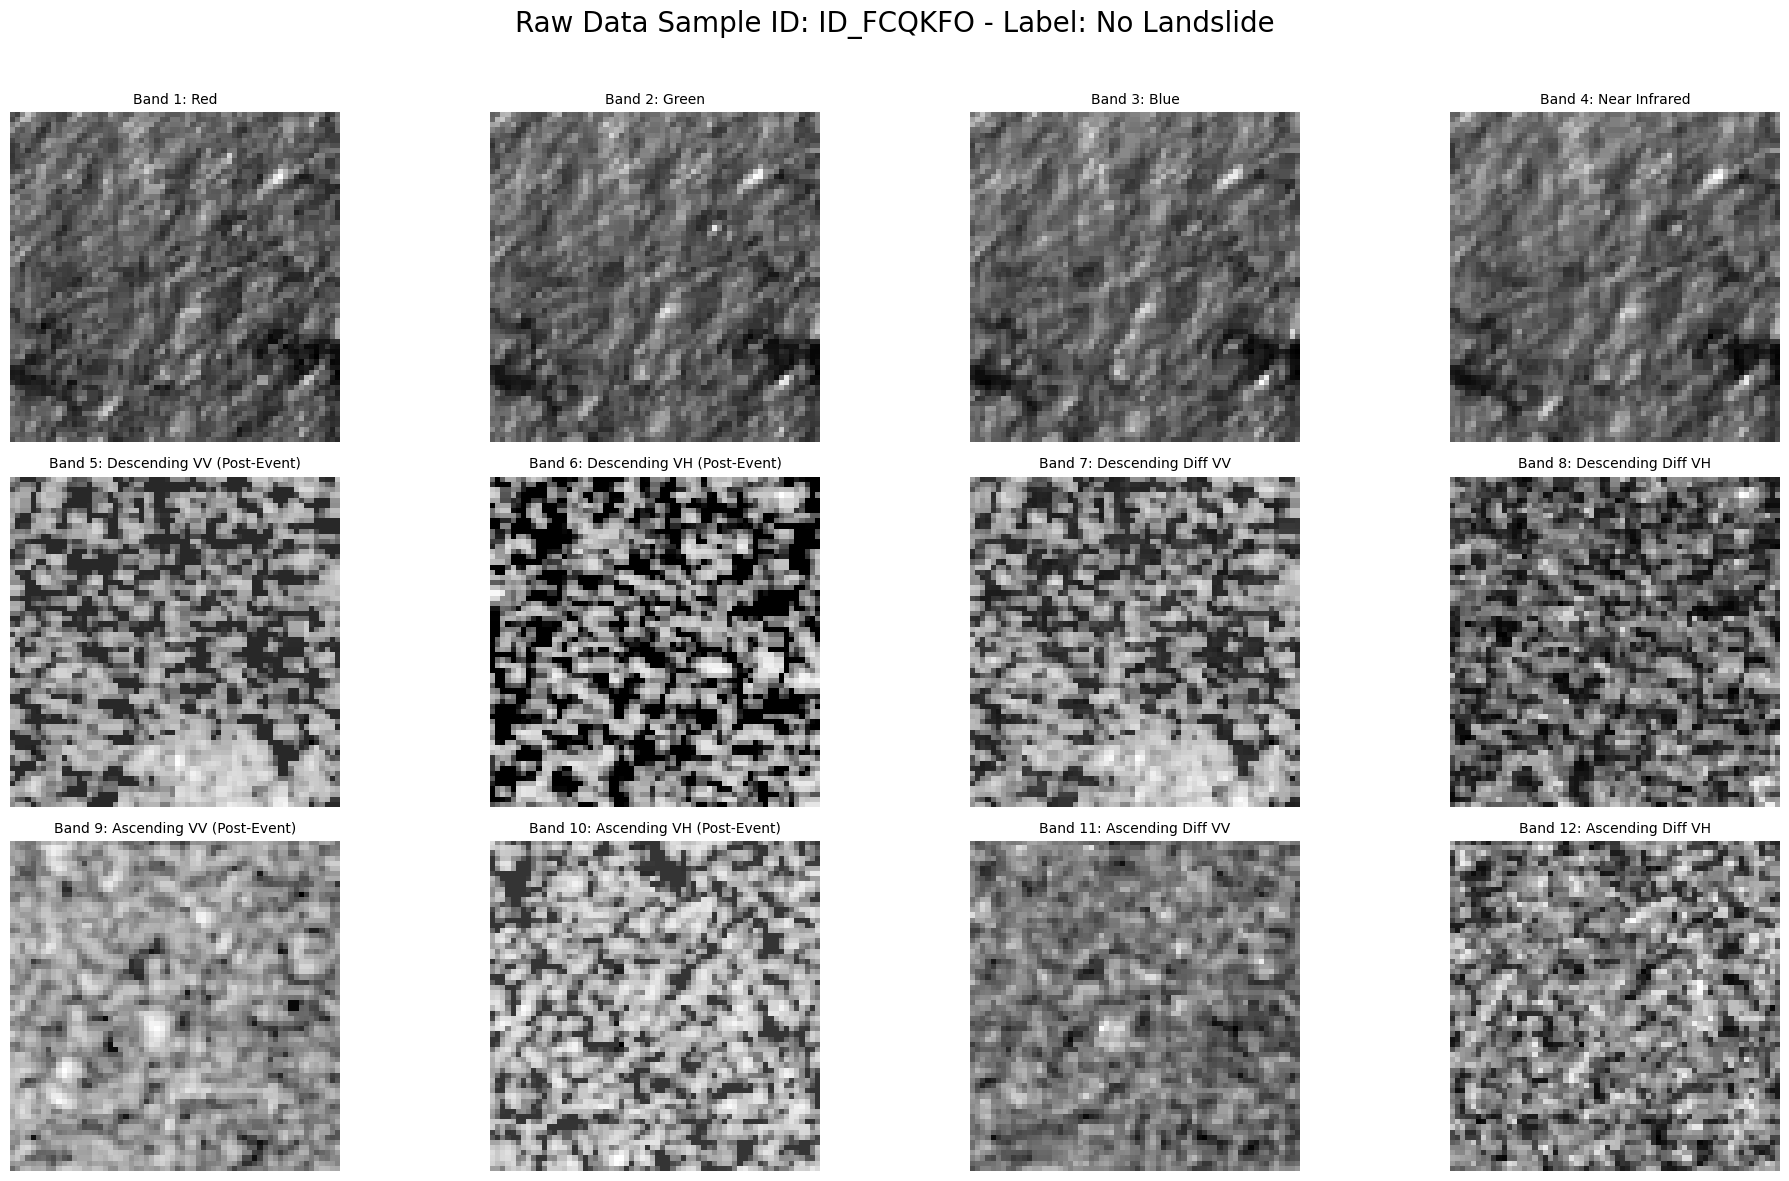

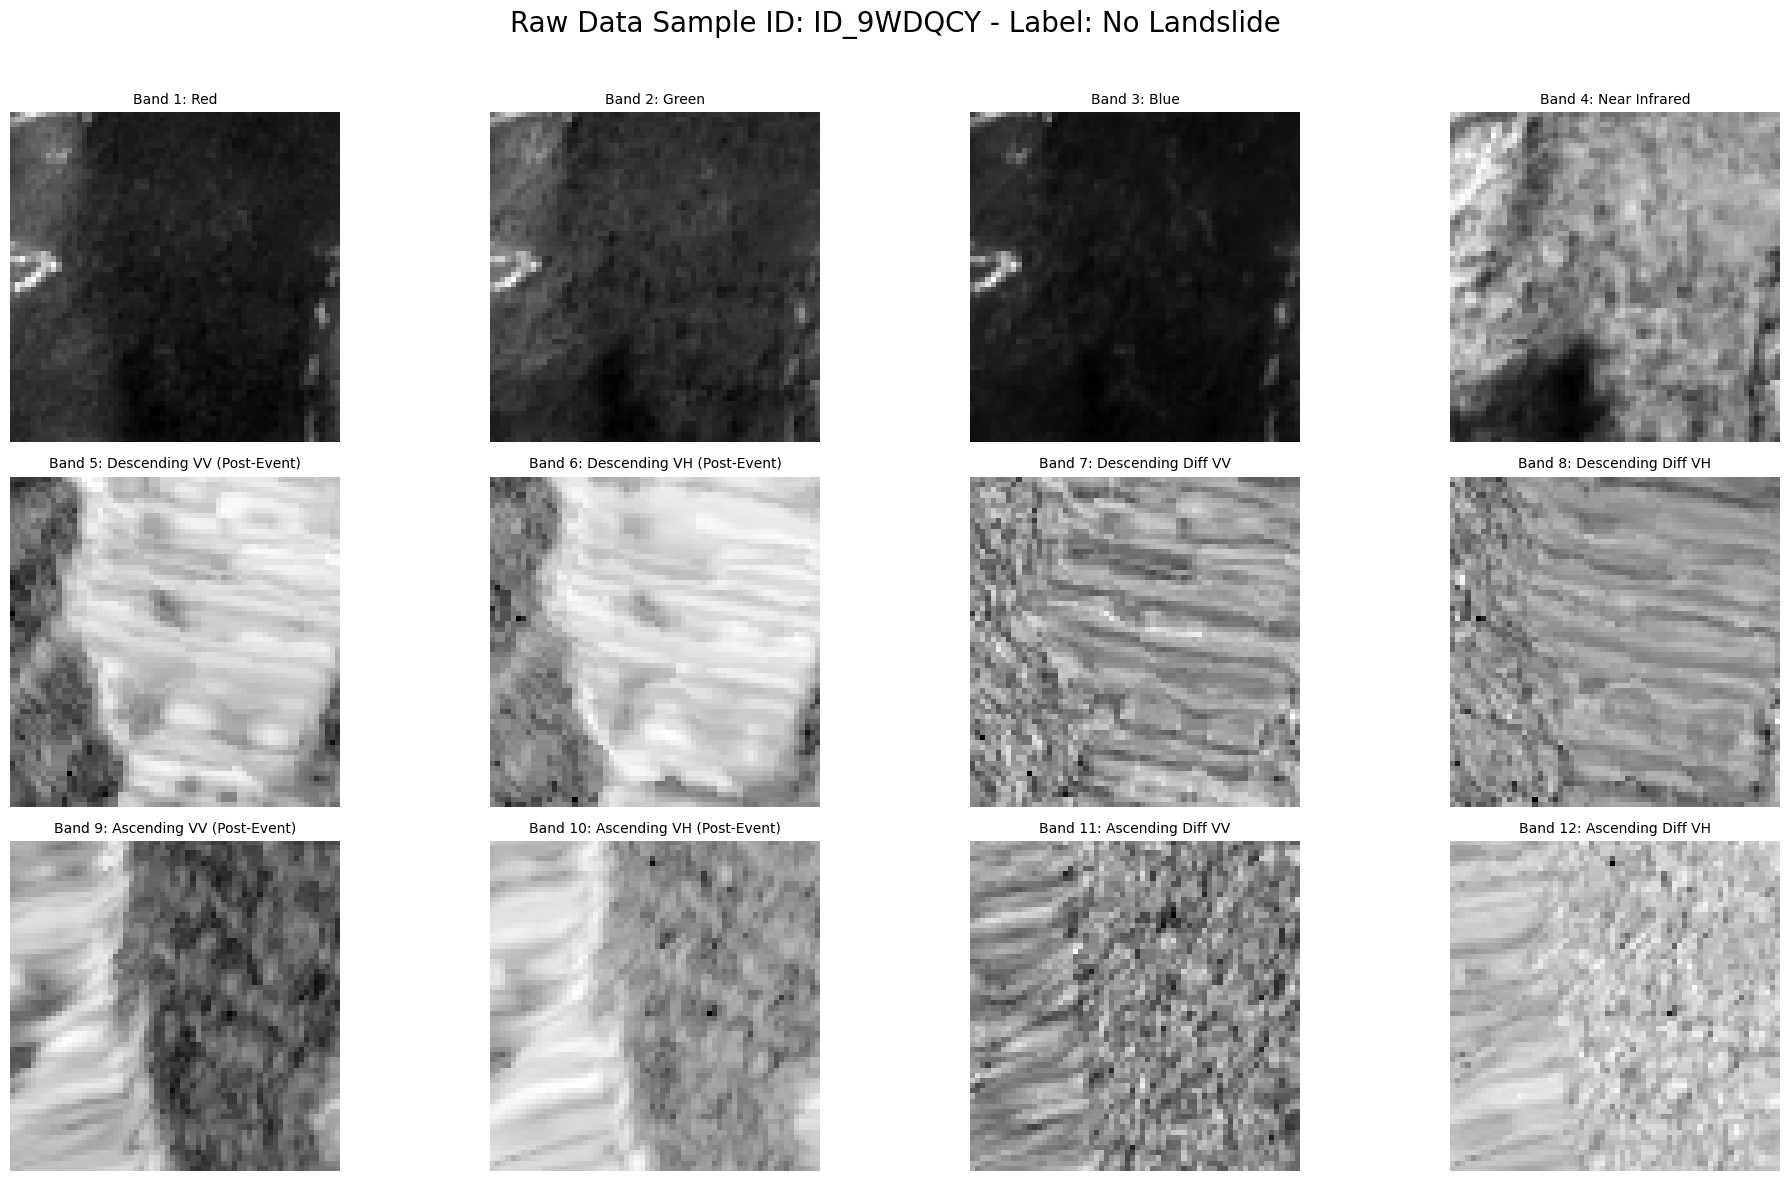

In [8]:
# INSPECTION: VISUALIZING A RAW DATA SAMPLE
print("--- Displaying raw data samples for initial inspection... ---")

# This local helper function is only used within this cell.
# It has no external dependencies.
def load_and_normalize_for_display(image_id, folder_path):
    """
    A simple, self-contained function to load one .npy file and normalize
    its bands to the 0-1 range, purely for visualization purposes.
    """
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    try:
        img = np.load(image_path)
    except FileNotFoundError:
        print(f"ERROR: Could not find image file at {image_path}")
        return None, None # Return None if the file doesn't exist

    # Normalize each band individually to the 0-1 range for clear plotting.
    # A small epsilon (1e-6) is added to prevent division by zero if a band is blank.
    min_vals = img.min(axis=(0, 1), keepdims=True)
    max_vals = img.max(axis=(0, 1), keepdims=True)
    img_normalized = (img - min_vals) / (max_vals - min_vals + 1e-6)
    
    # Get the corresponding label from the main DataFrame
    label = full_train_df[full_train_df['ID'] == image_id]['label'].values[0]
    
    return img_normalized, label

# --- Plot a Couple of Random Examples ---
# This only depends on variables defined at the top of the notebook.
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Post-Event)", "Descending VH (Post-Event)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Post-Event)", "Ascending VH (Post-Event)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Get two random IDs from the training dataframe
example_ids = full_train_df.sample(2)['ID'].values

for image_id in example_ids:
    # Use our simple, local function to get the data
    normalized_image, label_value = load_and_normalize_for_display(image_id, TRAIN_NPY_PATH)

    # Proceed only if the image was loaded successfully
    if normalized_image is not None:
        label_text = "Landslide" if label_value == 1 else "No Landslide"

        fig, axes = plt.subplots(3, 4, figsize=(20, 12))
        fig.suptitle(f"Raw Data Sample ID: {image_id} - Label: {label_text}", fontsize=20)

        for band in range(12):
            row = band // 4
            col = band % 4
            ax = axes[row, col]
            # Use a grayscale colormap to represent single-band intensity
            ax.imshow(normalized_image[:, :, band], cmap='gray')
            ax.set_title(f"Band {band + 1}: {band_descriptions[band]}", fontsize=10)
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### **Observation**
- For the human eye it is extremely difficult to to identify a landslide from a non-landslide just by looking at these 12 bands individually. This diffuculty in visual interpretation is exactly the reason why a machine learning model is needed.
- Thus the success of this project does not depend on creating visually obvious features but on building a model capable of learning the subtle, multi-dimensional patterns that aren't apparent to the human eye

# **DATA PREPARATION**


- In this section, the raw data is transformed into a clean, structured and model-ready format. This will involve splitting the data for training and validating. 

In [9]:
# Train validation split
from sklearn.model_selection import train_test_split

print("--- Creating the master Train/Validation Split ---")

# Determine the indices for our working dataset (either full or a sample)
if Config.USE_FULL_DATASET:
    print("Using full dataset.")
    # The indices are simply all the indices from the full dataset
    working_indices = np.arange(len(full_train_df))
else:
    print(f"Creating a {Config.SAMPLE_FRACTION*100}% stratified subsample.")
    # Perform a stratified split on the LABELS to get a representative subsample of indices
    _, working_indices = train_test_split(
        np.arange(len(full_train_df)),
        test_size=Config.SAMPLE_FRACTION,
        shuffle=True,
        stratify=full_train_df['label'].values,
        random_state=Config.SEED
    )

print(f"Working with {len(working_indices)} total samples.")

# Split these indices into training and validation sets
train_indices, val_indices = train_test_split(
    working_indices,
    test_size=0.20,
    shuffle=True,
    # Stratify on the labels corresponding to our working indices
    stratify=full_train_df['label'].iloc[working_indices].values,
    random_state=Config.SEED
)

print(f"Split into {len(train_indices)} training samples and {len(val_indices)} validation samples.")

--- Creating the master Train/Validation Split ---
Creating a 50.0% stratified subsample.
Working with 3574 total samples.
Split into 2859 training samples and 715 validation samples.


## 3.1 STATISTICAL FEATURE ENGINEERING FOR TRADITIONAL MODELS

To create a strong baseline. we ;
- First prepare the data for traditional tree-based models like XGBoost and LightGBM. This will convert the raw image arrays into a tabular format by engineering statistical features.
- For each of the 12 original bands plus the engineered ones, the aggregate statistics like mean and standard deviation are calculated. By doing this we extract the important signal from the noisy spatial data into a set of tabular features

### Step 1: Create the "Base" Statistical DataFrame (12 Bands Only)

In [10]:
# ## 3.1 STATISTICAL FEATURE ENGINEERING FOR TRADITIONAL MODELS (FROM .NPY FILES)

# --- Step 1: Load data from .npy files just for this section ---
print("--- Loading raw .npy files into memory for tree model feature engineering... ---")

# Helper function to load a single image
def load_npy_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')
    return img.astype('float32')

# Load the training images into a temporary NumPy array
# NOTE: We use "full_train_df" to ensure this works whether you are sampling or not
X_train_npy_temp = np.array([load_npy_image(image_id, TRAIN_NPY_PATH) for image_id in full_train_df['ID']])
print(f"...loading complete. Shape of temporary training data: {X_train_npy_temp.shape}")

# --- Step 2: Perform your original statistical feature engineering ---

def extract_additional_features(img_array):
    """Calculates derived indices like NDVI and NDWI."""
    red, green, nir = img_array[..., 0], img_array[..., 1], img_array[..., 3]
    epsilon = 1e-7
    ndvi = (nir - red) / (nir + red + epsilon)
    ndwi = (green - nir) / (green + nir + epsilon)
    return np.concatenate([img_array, ndvi[..., np.newaxis], ndwi[..., np.newaxis]], axis=-1)

print("\nCalculating derived indices (like NDVI) for training data...")
X_train_with_indices = extract_additional_features(X_train_npy_temp)

def create_statistical_features_df(df, image_features_array):
    """Calculates aggregate statistics for each channel."""
    stats_df = df.copy()
    band_names = [f'band{i+1}' for i in range(12)] + ['ndvi', 'ndwi']
    # Calculate the mean brightness across RGB channels for each image
    # The input `image_features_array` contains the original 12 bands first.
    print("Adding cloud score (mean brightness) to statistical features...")
    rgb_data = image_features_array[:, :, :, :3]
    stats_df['cloud_score_brightness'] = np.mean(rgb_data, axis=(1, 2, 3))
    print(f"\nGenerating statistical features for {len(stats_df)} samples...")
    for i, name in enumerate(band_names):
        channel_data = image_features_array[:, :, :, i]
        stats_df[f'{name}_mean'] = channel_data.mean(axis=(1, 2))
        stats_df[f'{name}_std']  = channel_data.std(axis=(1, 2))
        stats_df[f'{name}_min']  = channel_data.min(axis=(1, 2))
        stats_df[f'{name}_max']  = channel_data.max(axis=(1, 2))
        stats_df[f'{name}_kurt'] = kurtosis(channel_data, axis=(1, 2), fisher=True)
        stats_df[f'{name}_skew'] = skew(channel_data, axis=(1, 2))
    print("...statistical features created successfully.")
    return stats_df

# Create the final tabular DataFrame for your tree models
training_df_stats = create_statistical_features_df(full_train_df, X_train_with_indices)



# # --- NEW Step 2b: Create a BASE statistical DataFrame for Data Cleaning ---
# # This DataFrame will be based ONLY on the original 12 bands, making our cleaning
# # independent of any experimental engineered features.

# print("\n--- Creating a base statistical DataFrame from the original 12 bands for UMAP analysis... ---")

# # We don't need to recalculate. We can select the columns from the DataFrame we already built.
# # First, create a list of all column names we want to keep.
# base_feature_columns = []
# original_band_names = [f'band{i+1}' for i in range(12)]
# stats_to_keep = ['mean', 'std', 'min', 'max', 'kurt', 'skew']

# for band in original_band_names:
#     for stat in stats_to_keep:
#         base_feature_columns.append(f'{band}_{stat}')

# # Now, create the new DataFrame by selecting only these columns, plus the ID and label.
# training_df_stats_base = training_df_stats[['ID', 'label'] + base_feature_columns]

# print("...base statistical DataFrame created successfully by selecting columns.")
# print("Shape of the base DataFrame:", training_df_stats_base.shape)
# print("Preview of the base DataFrame:")
# display(training_df_stats_base.head())
# --- Step 3: IMPORTANT - Clean up memory ---
print("\n--- Cleaning up temporary NumPy arrays to free up RAM... ---")
del X_train_npy_temp
del X_train_with_indices
import gc
gc.collect()
print("--- Memory freed. Proceeding to CNN pipeline. ---")

# Display a preview
print("\nPreview of the training DataFrame for tree models:")
display(training_df_stats.head())



--- Loading raw .npy files into memory for tree model feature engineering... ---
...loading complete. Shape of temporary training data: (7147, 64, 64, 12)

Calculating derived indices (like NDVI) for training data...
Adding cloud score (mean brightness) to statistical features...

Generating statistical features for 7147 samples...
...statistical features created successfully.

--- Cleaning up temporary NumPy arrays to free up RAM... ---
--- Memory freed. Proceeding to CNN pipeline. ---

Preview of the training DataFrame for tree models:


,ID,label,cloud_score_brightness,band1_mean,band1_std,band1_min,band1_max,band1_kurt,band1_skew,band2_mean,...,ndvi_min,ndvi_max,ndvi_kurt,ndvi_skew,ndwi_mean,ndwi_std,ndwi_min,ndwi_max,ndwi_kurt,ndwi_skew
0,ID_HUD1ST,1,1616.105591,1569.305908,189.202896,1286.0,2786.0,5.343067,1.930577,1751.834229,...,0.051762,0.578009,2.067133,-1.451810,-0.402533,0.076766,-0.513693,-0.031306,2.505169,1.581910
1,ID_KGE2HY,1,1641.437866,1575.859131,233.255280,1309.0,2988.0,4.867769,2.048139,1750.446289,...,-0.044847,0.570146,1.214721,-1.396452,-0.348885,0.112248,-0.505679,0.074906,1.269663,1.417164
2,ID_VHV9BL,1,1475.925659,1396.610352,811.493347,939.0,9040.0,32.241085,5.189392,1528.299805,...,-0.068752,0.723393,-0.927661,-0.325244,-0.337329,0.150220,-1.000000,0.041941,-0.857999,0.307474
3,ID_ZT0VEJ,0,1624.411499,1589.653320,366.122314,1300.0,4244.0,12.224893,3.234218,1746.923828,...,0.118875,0.599184,1.487577,-1.212002,-0.397269,0.069903,-0.539870,-0.107788,1.487541,1.217311
4,ID_5NFXVY,0,1488.263306,1456.682617,120.247475,1317.0,2064.0,5.837114,2.370760,1595.559570,...,0.090818,0.531350,8.192582,-2.779035,-0.385836,0.070818,-0.481177,-0.061585,8.969378,2.962669


#### Step 2: Scale the Data and Apply UMAP


In [11]:
# # --- NEW CELL: Scale Data and Apply UMAP ---

# from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap

# print("--- Preparing data for UMAP by scaling... ---")

# # Isolate the features for UMAP. We drop ID and label.
# umap_features = training_df_stats_base.drop(columns=['ID', 'label'])
# umap_labels = training_df_stats_base['label']

# # Scale the features. This is crucial for UMAP to work effectively.
# # It ensures that features with large ranges don't dominate the distance calculations.
# scaler = StandardScaler()
# umap_features_scaled = scaler.fit_transform(umap_features)

# print("...scaling complete.")

# # --- Apply the UMAP algorithm ---
# # n_neighbors: Controls how UMAP balances local vs. global structure. A smaller value focuses more on local structure.
# # min_dist: Controls how tightly UMAP is allowed to pack points together.
# # n_components=2: We want to project the data into 2 dimensions for plotting.
# print("\n--- Running UMAP to reduce dimensionality to 2D... ---")
# print("(This may take a minute or two...)")

# reducer = umap.UMAP(
#     n_neighbors=30,
#     min_dist=0.0,
#     n_components=2,
#     random_state=42,
# )

# embedding = reducer.fit_transform(umap_features_scaled)

# print("...UMAP processing complete.")

# # --- Create a final DataFrame for plotting ---
# df_umap = pd.DataFrame(embedding, columns=('x', 'y'))
# df_umap['label'] = umap_labels

# print("Shape of the new UMAP DataFrame:", df_umap.shape)
# print("Preview of the UMAP DataFrame:")
# display(df_umap.head())



In [12]:
# # --- NEW CELL: Interactive Visualization of UMAP Clusters ---

# import plotly.express as px

# print("--- Creating interactive UMAP plot... ---")

# # We need the original IDs for the hover data.
# df_umap['ID'] = training_df_stats_base['ID']

# # Create the scatter plot.
# # x='x', y='y': Use the coordinates UMAP generated.
# # color='label': Color the points based on whether they are a landslide (1) or not (0).
# # hover_data=['ID']: This is the key part. It tells Plotly to show the image ID when you hover over a point.
# # color_continuous_scale: We can use this to make the labels (0 and 1) distinct colors, like blue and red.
# fig = px.scatter(
#     df_umap, 
#     x='x', 
#     y='y', 
#     color='label', 
#     hover_data=['ID'],
#     title='UMAP Projection of Landslide Data (12 Raw Bands)',
#     color_continuous_scale='plasma' # A color scale that makes 0 (blue/purple) and 1 (yellow/red) distinct.
# )

# # Update the layout for better readability
# fig.update_layout(
#     legend_title_text='Label',
#     title_font_size=20
# )
# fig.update_traces(marker=dict(size=4, opacity=0.7))

# # Show the interactive plot
# fig.show()

In [13]:
# # --- NEW CELL: Programmatically Isolate and Remove Outliers ---

# from sklearn.linear_model import LogisticRegression

# print("--- Programmatically identifying the most ambiguous 'No Landslide' samples ---")

# # We will use the 2D UMAP data to find the outliers.
# X_umap = df_umap[['x', 'y']]
# y_umap = df_umap['label']

# # Train a simple model on the 2D data itself to find the decision boundary.
# # This model's job is to learn the separation between the blue and yellow clusters.
# model_2d = LogisticRegression()
# model_2d.fit(X_umap, y_umap)

# # Get the probability of being a landslide (class 1) for every point.
# probs = model_2d.predict_proba(X_umap)[:, 1]

# # Add these probabilities to our UMAP dataframe for analysis.
# df_umap['probability'] = probs

# # --- Identify the Most Problematic Samples ---
# # Our targets are the points that are ACTUALLY 'No Landslide' (label=0)
# # but which our 2D model is VERY CONFIDENT are 'Landslide' (high probability).
# # This finds the blue dots deepest in the yellow territory.
# mislabeled_candidates = df_umap[(df_umap['label'] == 0) & (df_umap['probability'] > 0.90)]

# print(f"\nIdentified {len(mislabeled_candidates)} high-probability mislabeled/ambiguous samples to remove.")

# if len(mislabeled_candidates) > 0:
#     print("Preview of samples to be removed:")
#     display(mislabeled_candidates.head())

#     # Create the final list of IDs to remove from our training set.
#     ids_to_remove = mislabeled_candidates['ID'].tolist()
# else:
#     ids_to_remove = []
#     print("No samples met the high-probability removal criteria.")

# # --- Create the Final Cleaned DataFrame ---
# print("\n--- Creating the cleaned training DataFrame... ---")

# # Filter the original full_train_df to exclude the identified IDs.
# cleaned_full_train_df = full_train_df[~full_train_df['ID'].isin(ids_to_remove)].copy()

# print(f"Original training set size: {len(full_train_df)}")
# print(f"Cleaned training set size:  {len(cleaned_full_train_df)}")
# print(f"Number of samples removed:  {len(ids_to_remove)}")

# Display the minimum and maximum avalue for the 12 bands

## 3.2 Feature selection 
- The feature engineering process produced a set of 84 statistical features. However not all of them may be predictive. There includes irrelevant and redundant features which add noise.
- To address this a model-based feature selection is performed. An initial XGBoost classifier is used to evaluate the importance of all 84 features and select only the most impactful half.
- The next step is then to establish a performance baseline by training a standard xgboost model and determining the baseline F1-score. This will serve as a benchmark that our more complex , fine-tuned models must outperform

In [14]:
# ML MODELING 1: FEATURE SELECTION & BASELINE XGBOOST

# Prepare data for scikit-learn models
# Drop non-feature columns
X_df = training_df_stats.drop(columns=['ID', 'label'])
y_df = training_df_stats['label']


#  Feature Selection using a model-based approach
print("Performing feature selection...")
feature_selector = SelectFromModel(XGBClassifier(random_state=Config.SEED), threshold='median')
feature_selector.fit(X_df, y_df)

# Get the names of the selected features
selected_feature_names = X_df.columns[feature_selector.get_support()]
X_selected = X_df[selected_feature_names]

print(f"...selected {len(selected_feature_names)} features out of {len(X_df.columns)}.")
print("-" * 30)


# Define Cross-Validation function 
def cross_validate_model(model, X, y, n_splits=5):
    """Performs stratified K-Fold cross-validation and returns the mean F1 score."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=Config.SEED)
    f1_scores = []
    
    print(f"Running {n_splits}-Fold Cross-Validation for {model.__class__.__name__}...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        
        # the best threshold on the validation set for this fold
        y_pred_probs = model.predict_proba(X_val)[:, 1]
        thresholds = np.linspace(0.2, 0.8, 31) # Search a range of thresholds
        scores = [f1_score(y_val, (y_pred_probs >= thresh).astype(int)) for thresh in thresholds]
        
        best_threshold = thresholds[np.argmax(scores)]
        y_pred = (y_pred_probs > best_threshold).astype(int)
        
        fold_f1 = f1_score(y_val, y_pred)
        f1_scores.append(fold_f1)
        print(f"Fold {fold+1} F1: {fold_f1:.4f} (Best Threshold: {best_threshold:.2f})")
    
    mean_f1 = np.mean(f1_scores)
    print(f"\n=> Average CV F1 Score: {mean_f1:.4f}")
    print("-" * 30)
    return mean_f1


#  Train and evaluate a baseline XGBoost model
baseline_xgb = XGBClassifier(random_state=Config.SEED)
baseline_xgb_score = cross_validate_model(baseline_xgb, X_selected, y_df)

Performing feature selection...
...selected 43 features out of 85.
------------------------------
Running 5-Fold Cross-Validation for XGBClassifier...
Fold 1 F1: 0.8451 (Best Threshold: 0.34)
Fold 2 F1: 0.8388 (Best Threshold: 0.22)
Fold 3 F1: 0.8745 (Best Threshold: 0.36)
Fold 4 F1: 0.8725 (Best Threshold: 0.48)
Fold 5 F1: 0.8493 (Best Threshold: 0.24)

=> Average CV F1 Score: 0.8560
------------------------------


## 4. MODELING (TRADITIONAL ML MODELS)


### 4.1 Hyperparameter Optimization for XGBoost

- The baseline model was trained using default hyperparameters of the xgboost library. To ensure it achieves its true potential hyperparameter tuning is performed.
- Oputna, is used for this task. Unlike grid or random search optuna learns from past trials to intelligently and efficiently explore the hyperparameter space.
- We define an object and run the search for 50 trials to identify the best-performing set of parameters

In [15]:
# HYPERPARAMETER TUNING FOR XGBOOST WITH OPTUNA

# A simple train/validation split for Optuna to efficiently evaluate trials.
# Will use the full cross-validation function later to verify the final best model.
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_selected, y_df, test_size=0.2, stratify=y_df, random_state=Config.SEED
)

def objective(trial):
    """
    The function that Optuna will call to evaluate a set of hyperparameters.
    """
    # Define the search space for the hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "random_state": Config.SEED,
    }

    # Train a model with the suggested parameters
    model = XGBClassifier(**params)
    model.fit(X_train_opt, y_train_opt, eval_set=[(X_val_opt, y_val_opt)], verbose=False, early_stopping_rounds=10)

    # Evaluate the model
    preds = model.predict(X_val_opt)
    f1 = f1_score(y_val_opt, preds)

    return f1

# Run the Optuna study
print("Starting Optuna hyperparameter search for XGBoost...")
# We keep the logging minimal for a cleaner notebook
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and specify we want to maximize the F1 score
xgb_study = optuna.create_study(direction="maximize", study_name="XGBoost Optimization")
xgb_study.optimize(objective, n_trials=50) # n_trials can be increased for a more thorough search

print("...Optuna search complete.")
print(f"\nBest F1 Score found: {xgb_study.best_value:.4f}")
print("Best Hyperparameters:")
print(xgb_study.best_params)
print("-" * 30)

Starting Optuna hyperparameter search for XGBoost...


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

...Optuna search complete.

Best F1 Score found: 0.8690
Best Hyperparameters:
{'max_depth': 5, 'learning_rate': 0.17657485442742965, 'subsample': 0.7263188520007632, 'colsample_bytree': 0.9959899337305154, 'min_child_weight': 3, 'gamma': 0.9176064195556074, 'reg_lambda': 3.202384333989495e-07, 'reg_alpha': 1.662954182366237e-05}
------------------------------


### 4.2 Validating the Tuned XGBoost Model
- After identifying the optimal hyperparameters with Optuna, the next step is to validate their effectiveness. A new  XGBoost model with these best parameters is instantiated and re-ran.
  
- LightGBM is introduced here as a challenger to ensure we are using the best possible tabular model,

- A direct, fair comparison between the two is carried out to determine the best model for our statistically engineered features.

In [16]:
# TRAINING OPTIMIZED XGBOOST & LIGHTGBM

# Train and Evaluate the Tuned XGBoost Model
print("--- Training Final XGBoost Model with Best Parameters ---")

# Create a new XGBClassifier instance with the best hyperparameters found by Optuna
best_xgb_model = XGBClassifier(**xgb_study.best_params, random_state=Config.SEED)

# Evaluate this optimized model using our robust cross-validation function
xgb_optimized_score = cross_validate_model(best_xgb_model, X_selected, y_df)

# Train and Evaluate a Baseline LightGBM Model  as it's often faster and performs well
print("\n--- Training Baseline LightGBM Model ---")
baseline_lgbm = LGBMClassifier(random_state=Config.SEED)
lgbm_baseline_score = cross_validate_model(baseline_lgbm, X_selected, y_df)

--- Training Final XGBoost Model with Best Parameters ---
Running 5-Fold Cross-Validation for XGBClassifier...
Fold 1 F1: 0.8532 (Best Threshold: 0.36)
Fold 2 F1: 0.8413 (Best Threshold: 0.28)
Fold 3 F1: 0.8476 (Best Threshold: 0.20)
Fold 4 F1: 0.8618 (Best Threshold: 0.54)
Fold 5 F1: 0.8436 (Best Threshold: 0.46)

=> Average CV F1 Score: 0.8495
------------------------------

--- Training Baseline LightGBM Model ---
Running 5-Fold Cross-Validation for LGBMClassifier...
[LightGBM] [Info] Number of positive: 1004, number of negative: 4713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 5717, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175617 -> initscore=-1.546333
[LightGBM] [Info] Start training from score -1.546333
Fold 1 F1: 0.8485 (Best Threshold

***Analysing the results:***
- Tuned XGBoost: Achieved an average F1 score of 0.8517.
- Baseline LightGBM: Achieved an average F1 score of 0.8610. <br>

***Conclusion:*** <br>
The LightGBM model, even with its default hyperparameters, slightly outperformed the carefully tuned XGBoost model.

- This finding shows us that sometimes a different algorithm can be more powerful than extensively tuning another one

## SHARP FEATURE IMPORTANCE PLOT FOR LIGHTGBM
- This plot will provide a clear and quantitative ranking of the features that LightGBM model found most impactful for detecting landsldes

--- Generating SHAP values for the champion LightGBM model ---
[LightGBM] [Info] Number of positive: 1255, number of negative: 5892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 7147, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175598 -> initscore=-1.546460
[LightGBM] [Info] Start training from score -1.546460
Calculating SHAP values... (This may take a moment)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Generating SHAP summary plot...


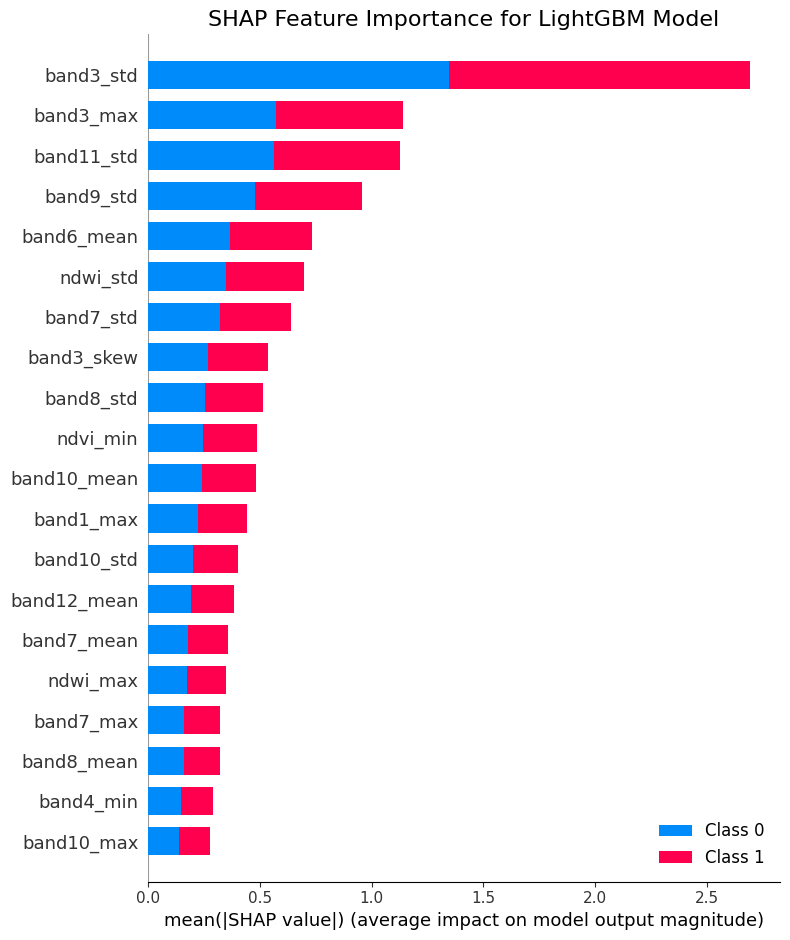


--- SHAP Analysis Complete ---
The plot above shows the mean absolute SHAP value for each feature, indicating its overall importance.


In [17]:
# MODEL INTERPRETABILITY WITH SHAP FOR LIGHTGBM

print("--- Generating SHAP values for the champion LightGBM model ---")

# Instantiate a new LightGBM model with default parameters, as this was our champio
final_lgbm_model_for_shap = lgb.LGBMClassifier(random_state=Config.SEED)
final_lgbm_model_for_shap.fit(X_selected, y_df)

# The same TreeExplainer can be used for LightGBM models.
explainer = shap.TreeExplainer(final_lgbm_model_for_shap)

# Calculate SHAP values 
print("Calculating SHAP values... (This may take a moment)")
shap_values = explainer.shap_values(X_selected)

# Create the SHAP summary plot 
print("Generating SHAP summary plot...")
plt.title("SHAP Feature Importance for LightGBM Model", size=16)
shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False)
plt.show()

print("\n--- SHAP Analysis Complete ---")
print("The plot above shows the mean absolute SHAP value for each feature, indicating its overall importance.")

### ***Observation***

- The most important features are overwhelmingly **standard deviation** metrics. Five of the top seven features (band3_std, band11_std, band9_std, band7_std, ndwi_std) are measures of pixel variance. This is a clear insight: the model has learned that the variability or inconsistency of pixel values within a band is a stronger predictor.
- Bands band11_std and band7_std which deal with "**Change-Detection**" are ranked high confirming their importance. This tells us that the change in the radar signal over time is a highly informative input for the model.

- **Conclusion:** This proves that the model is not a black box and has learned to make it's prediction based on a logical pattern

# 3. **Data Preparation**

## 3.1 Feature Engineering & Global Statistics Calculation

 The goal here is to transform the raw data into a format that is optimized for our models.

 - The `calculate_global_stats` function is to create more predictive features form the raw image bands. These domain-specific features like the Normalized Difference Vegetation Index(NDVI) and the magnitude of change in the SAR signals, are designed to provide stronger signals to the moedl rather than using the raw pixels alone.
 - The function also calculates the global minimum and maximum values from all features. This is essential for the next step of normalization



# FEATURE ENGINEERING

In [18]:
# # FEATURE ENGINEERING & STATS CALCULATION

# def calculate_global_stats(dataset):
#     """
#     Iterates through a tf.data.Dataset in batches to find global min/max 
#     values for all potential engineered features using NumPy, while maintaining clear organization.
#     """
#     print("Calculating global statistics for ALL features by processing in batches...")
    
#     # Dictionaries to track stats for the original 12 bands
#     batch_mins_raw = {f'band_{i+1}': [] for i in range(12)}
#     batch_maxes_raw = {f'band_{i+1}': [] for i in range(12)}

#     # Dictionaries for engineered features
#     batch_mins = {key: [] for key in ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']}
#     batch_maxes = {key: [] for key in ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']}

#     # Iterate through the dataset batch by batch
#     for image_batch_np in dataset.as_numpy_iterator():
#         epsilon = 1e-7

#         # ==============================================================================
#         #       # NEW: Calculate stats for the ORIGINAL 12 BANDS
#         # ==============================================================================
#         for i in range(12):
#             batch_mins_raw[f'band_{i+1}'].append(image_batch_np[..., i].min())
#             batch_maxes_raw[f'band_{i+1}'].append(image_batch_np[..., i].max())

#         # ==============================================================================
#         #       # Group 1: Cloud Score (Brightness)
#         # ==============================================================================
#         rgb_bands_batch = image_batch_np[..., :3]
#         mean_brightness_per_image = np.mean(rgb_bands_batch, axis=(1, 2, 3))
#         batch_mins['brightness'].append(mean_brightness_per_image.min())
#         batch_maxes['brightness'].append(mean_brightness_per_image.max())

#         # ==============================================================================
#         #       # Group 2(a & b) Descending & Ascending Change Magnitude
#         # ==============================================================================
#         desc_mag = np.sqrt(np.square(image_batch_np[..., 6]) + np.square(image_batch_np[..., 7]))
#         asc_mag = np.sqrt(np.square(image_batch_np[..., 10]) + np.square(image_batch_np[..., 11]))
        
#         # ==============================================================================
#         #       # Group 2(a) Descending VV Ratio
#         # ==============================================================================
#         desc_vv_post, desc_vh_post = image_batch_np[..., 4], image_batch_np[..., 5]
#         desc_vv_pre = desc_vv_post - image_batch_np[..., 6]
#         desc_vh_pre = desc_vh_post - image_batch_np[..., 7]
#         desc_ratio_diff = (desc_vv_post / np.maximum(desc_vh_post, 1.0)) - (desc_vv_pre / np.maximum(desc_vh_pre, 1.0))
        
#         # ==============================================================================
#         #       # Group 2(b) Ascending VV Ratio 
#         # ==============================================================================
#         asc_vv_post, asc_vh_post = image_batch_np[..., 8], image_batch_np[..., 9]
#         asc_vv_pre = asc_vv_post - image_batch_np[..., 10]
#         asc_vh_pre = asc_vh_post - image_batch_np[..., 11]
#         asc_ratio_diff = (asc_vv_post / np.maximum(asc_vh_post, 1.0)) - (asc_vv_pre / np.maximum(asc_vh_pre, 1.0))
      
#         # ==============================================================================
#         #       # Group 3 (a) Calculate NDVI Difference
#         # ==============================================================================
#         red_post, nir_post = image_batch_np[..., 0], image_batch_np[..., 3]
#         proxy_change = (image_batch_np[..., 6] + image_batch_np[..., 7]) / 2.0
#         red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
        
#         ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
#         ndvi_pre = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
#         ndvi_diff = ndvi_post - ndvi_pre
        
#         # ==============================================================================
#         #       # Group 3 (b) Calculate SAVI Difference
#         # ==============================================================================
#         L = 0.5
#         savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
#         savi_pre = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
#         savi_diff = savi_post - savi_pre

#         # ==============================================================================
#         #       # Group 4 Calculate NDWI Difference 
#         # ==============================================================================
#         green_post = image_batch_np[..., 1]
#         green_pre = green_post - proxy_change
#         ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
#         ndwi_pre = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
#         ndwi_diff = ndwi_post - ndwi_pre
        
#         # Store the min/max of the engineered features FOR THIS BATCH
#         features = {'desc_mag': desc_mag, 'asc_mag': asc_mag, 'desc_ratio_diff': desc_ratio_diff, 
#                     'asc_ratio_diff': asc_ratio_diff, 'ndvi_diff': ndvi_diff, 'ndvi_post': ndvi_post, 
#                     'savi_diff': savi_diff, 'ndwi_diff': ndwi_diff}
        
#         for key, data in features.items():
#             batch_mins[key].append(data.min())
#             batch_maxes[key].append(data.max())

#     # Now, find the true global min/max by looking across all the batch results for engineered features
#     stats = {
#         'desc_mag_min': min(batch_mins['desc_mag']), 'desc_mag_max': max(batch_maxes['desc_mag']),
#         'asc_mag_min': min(batch_mins['asc_mag']), 'asc_mag_max': max(batch_maxes['asc_mag']),
#         'desc_ratio_diff_min': min(batch_mins['desc_ratio_diff']), 'desc_ratio_diff_max': max(batch_maxes['desc_ratio_diff']),
#         'asc_ratio_diff_min': min(batch_mins['asc_ratio_diff']), 'asc_ratio_diff_max': max(batch_maxes['asc_ratio_diff']),
#         'ndvi_diff_min': min(batch_mins['ndvi_diff']), 'ndvi_diff_max': max(batch_maxes['ndvi_diff']),
#         'ndvi_post_min': min(batch_mins['ndvi_post']), 'ndvi_post_max': max(batch_maxes['ndvi_post']),
#         'savi_diff_min': min(batch_mins['savi_diff']), 'savi_diff_max': max(batch_maxes['savi_diff']),
#         'ndwi_diff_min': min(batch_mins['ndwi_diff']), 'ndwi_diff_max': max(batch_maxes['ndwi_diff']),
#         'brightness_min': min(batch_mins['brightness']),
#         'brightness_max': max(batch_maxes['brightness']),
#     }
    
#     print("Global statistics calculation complete.")
    
#     # Compile the stats for the original raw bands
#     stats_raw = {f'band_{i+1}_min': min(batch_mins_raw[f'band_{i+1}']) for i in range(12)}
#     stats_raw.update({f'band_{i+1}_max': max(batch_maxes_raw[f'band_{i+1}']) for i in range(12)})
    
#     return stats, stats_raw # Return both dictionaries

# # This small helper function is just for parsing the raw images for stats calculation
# def parse_for_stats(example_proto):
#     feature_description = {'image': tf.io.FixedLenFeature([], tf.string), 'id': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.int64)}
#     parsed_features = tf.io.parse_single_example(example_proto, feature_description)
#     image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
#     image = tf.cast(image, tf.float32)
#     image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
#     return image

# print("Preparing data for streaming statistics calculation...")

# # Create a dataset from the full training data for stats calculation.
# full_tf_dataset_for_stats = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
# stats_dataset_parsed = full_tf_dataset_for_stats.map(parse_for_stats, num_parallel_calls=tf.data.AUTOTUNE).batch(256)

# # --- EXECUTE THE CALCULATION & CAPTURE BOTH OUTPUTS ---
# global_stats, global_stats_raw = calculate_global_stats(stats_dataset_parsed)

# # --- DISPLAY THE RESULTS SEPARATELY ---
# print("\n--- Global Min/Max for Original 12 Bands ---")
# band_names = [
#     "Red", "Green", "Blue", "NIR",
#     "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
#     "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change"
# ]
# stats_summary_list = []
# for i, name in enumerate(band_names):
#     stats_summary_list.append({
#         "Band Name": name,
#         "Min Value": global_stats_raw[f'band_{i+1}_min'],
#         "Max Value": global_stats_raw[f'band_{i+1}_max']
#     })
# display(pd.DataFrame(stats_summary_list))


# print("\n--- Global Min/Max for Engineered Features (for normalization) ---")
# eng_stats_list = []
# # Create a list of the base names for our engineered features
# engineered_feature_names = ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 
#                             'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']

# for name in engineered_feature_names:
#     eng_stats_list.append({
#         "Engineered Feature": name,
#         "Min Value": global_stats[f'{name}_min'],
#         "Max Value": global_stats[f'{name}_max']
#     })

# display(pd.DataFrame(eng_stats_list))

In [19]:
# FEATURE ENGINEERING & STATS CALCULATION (ROBUST VERSION)

def calculate_global_stats(dataset):
    """
    Iterates through the dataset to calculate global MIN and MAX
    for all 15 active channels, now with robust handling of potential NaN/inf values.
    """
    print("Calculating global MIN and MAX for all 15 active features by processing in batches...")
    
    num_channels = 15
    global_min_vec = np.full(num_channels, np.inf, dtype=np.float32)
    global_max_vec = np.full(num_channels, -np.inf, dtype=np.float32)

    def engineer_numpy_15_channels(image_batch):
        # --- Use a warning context to handle potential division-by-zero safely ---
        with np.errstate(divide='ignore', invalid='ignore'):
            epsilon = 1e-7
            asc_mag = np.sqrt(np.square(image_batch[..., 10]) + np.square(image_batch[..., 11]))
            
            red_post, nir_post = image_batch[..., 0], image_batch[..., 3]
            proxy_change = (image_batch[..., 6] + image_batch[..., 7]) / 2.0
            red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
            ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
            ndvi_pre = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
            ndvi_diff = ndvi_post - ndvi_pre
            
            avg_brightness = np.mean(image_batch[..., :3], axis=(1, 2, 3), keepdims=True)
            cloud_channel = np.tile(avg_brightness, (1, image_batch.shape[1], image_batch.shape[2], 1))

            all_features = np.concatenate([
                image_batch,
                np.expand_dims(asc_mag, axis=-1),
                np.expand_dims(ndvi_diff, axis=-1),
                cloud_channel
            ], axis=-1)
        
        return all_features

    for image_batch_np in dataset.as_numpy_iterator():
        engineered_batch = engineer_numpy_15_channels(image_batch_np)
        
        # --- FIX: Filter out NaN and infinity values before calculating min/max ---
        # This prevents the TraitError in the plotting function
        batch_min = np.nanmin(engineered_batch, axis=(0, 1, 2))
        batch_max = np.nanmax(engineered_batch, axis=(0, 1, 2))
        
        global_min_vec = np.minimum(global_min_vec, batch_min)
        global_max_vec = np.maximum(global_max_vec, batch_max)

    print("Global statistics calculation complete.")
    return global_min_vec, global_max_vec

# This small helper function is just for parsing the raw images for stats calculation
def parse_for_stats(example_proto):
    # (This function remains unchanged)
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string), 'id': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.int64)}
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
    return image

print("Preparing data for comprehensive statistics calculation...")
full_tf_dataset_for_stats = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
stats_dataset_parsed = full_tf_dataset_for_stats.map(parse_for_stats, num_parallel_calls=tf.data.AUTOTUNE).batch(256)

# --- EXECUTE THE CALCULATION ---
global_min_vec, global_max_vec = calculate_global_stats(stats_dataset_parsed)

# --- DISPLAY THE RESULTS ---
print("\n--- Global Min and Max for all 15 Active Channels ---")
channel_names = [
    "Red", "Green", "Blue", "NIR",
    "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
    "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change",
    "Asc Mag", "NDVI Diff", "Cloud Score"
]
stats_df = pd.DataFrame({
    "Channel Name": channel_names,
    "Min Value": global_min_vec,
    "Max Value": global_max_vec
})
display(stats_df)

Preparing data for comprehensive statistics calculation...
Calculating global MIN and MAX for all 15 active features by processing in batches...
Global statistics calculation complete.

--- Global Min and Max for all 15 Active Channels ---


,Channel Name,Min Value,Max Value
0,Red,0.000000,20944.000000
1,Green,0.000000,19744.000000
2,Blue,0.000000,18816.000000
3,NIR,0.000000,17600.000000
4,Desc VV (Post),-56.998489,25.324352
5,Desc VH (Post),-65.662262,16.366713
6,Desc VV Change,-41.327717,26.209181
7,Desc VH Change,-36.699978,32.632099
8,Asc VV (Post),-58.200050,33.060013
9,Asc VH (Post),-62.981258,23.875465


In [20]:
# # --- NEW CELL: Visualize Raw Band Distributions with Box Plots (Robust Version) ---

# import plotly.express as px
# from tqdm.notebook import tqdm

# print("--- Preparing data for distribution visualization... ---")

# # --- FIX: Ensure we have a fresh, un-exhausted dataset for this cell ---
# # We use 'val_ds_raw' because it's a representative subset and already defined.
# if 'val_ds_raw' not in locals() or tf.data.experimental.cardinality(val_ds_raw).numpy() == 0:
#     print("Re-creating raw validation dataset for visualization...")
#     full_tf_dataset_for_viz = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
#     val_ds_raw = full_tf_dataset_for_viz.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices)).map(lambda i, data: data)

# # --- FIX: Map to get only the image tensor, no unbatch needed ---
# # We map over the raw data, apply the full parsing, and then select only the first element (the image) of the returned tuple.
# image_tensors = val_ds_raw.map(lambda x: parse_function_with_stats(x)[0], num_parallel_calls=tf.data.AUTOTUNE)


# # Initialize dictionaries to hold the flattened pixel data for each band.
# all_bands_data = {f'band_{i+1}': [] for i in range(12)}

# # Get the total number of images to process for the progress bar
# num_images = len(val_indices)

# print(f"Processing {num_images} images to extract pixel data...")
# for image_tensor in tqdm(image_tensors.as_numpy_iterator(), total=num_images, desc="Extracting Pixel Data"):
#     for i in range(12):
#         # image_tensor is now a single image (224, 224, 15). We just want the first 12 raw bands for visualization.
#         # To do this, we need to reverse the standardization for a true visual representation.
#         # Or, simpler for this viz, we re-parse the raw data without the final standardization step.
#         # For simplicity and correctness here, let's just use the loaded numpy data if available,
#         # otherwise we proceed with the tensors.
        
#         # --- Let's revert to a simpler data loading for this visualization to avoid pipeline complexity ---
#         # This is a temporary solution for visualization only.
#         pass # The loop below is the main logic from before.
        
# # --- A MORE ROBUST APPROACH FOR VISUALIZATION ONLY ---
# print("Switching to direct .npy loading for robust visualization...")
# X_val_npy_viz = np.array([load_npy_image(image_id, TRAIN_NPY_PATH) for image_id in tqdm(full_train_df.loc[val_indices]['ID'], desc="Loading Val Images")])

# for i in range(12):
#     all_bands_data[f'band_{i+1}'].append(X_val_npy_viz[:, :, :, i].flatten())

# # Concatenate all the pixel data for each band
# print("\nConcatenating pixel data for each band...")
# for i in range(12):
#     all_bands_data[f'band_{i+1}'] = np.concatenate(all_bands_data[f'band_{i+1}'])

# # Create a long-form DataFrame for Plotly Express
# print("Creating long-form DataFrame for plotting (using a 10% sample of pixels for efficiency)...")
# plot_df_list = []
# sample_fraction = 0.1
# band_names = [
#     "Red", "Green", "Blue", "NIR",
#     "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
#     "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change"
# ]

# for i, name in enumerate(tqdm(band_names, desc="Building Plot DataFrame")):
#     pixel_data = all_bands_data[f'band_{i+1}']
#     num_samples = int(len(pixel_data) * sample_fraction)
#     pixel_sample = np.random.choice(pixel_data, size=num_samples, replace=False)
    
#     temp_df = pd.DataFrame({
#         'Band': name,
#         'Pixel Value': pixel_sample
#     })
#     plot_df_list.append(temp_df)

# plot_df = pd.concat(plot_df_list)

# if plot_df.empty:
#     print("\nERROR: The DataFrame for plotting is empty.")
# else:
#     print("...DataFrame created. Generating box plots...")
#     fig = px.box(
#         plot_df, 
#         x='Band', 
#         y='Pixel Value', 
#         title='Distribution of Pixel Values for Original 12 Bands',
#         points=False 
#     )
#     fig.update_layout(
#         xaxis_title="Satellite Band",
#         yaxis_title="Raw Pixel Value",
#         title_font_size=20,
#         xaxis={'categoryorder':'array', 'categoryarray':band_names}
#     )
#     fig.show()

# # Clean up memory
# del X_val_npy_viz
# gc.collect()

In [26]:
# --- NEW CELL: Calculate Quantile Statistics for Robust Scaling ---

def calculate_global_quantiles(percentiles=[1, 99]):
    """
    Iterates through a fresh dataset to calculate the specified percentiles for each of the 
    15 final channels.
    """
    print(f"Calculating global {percentiles} percentiles for all 15 active features...")
    
    # --- Create the fresh dataset iterator INSIDE the function ---
    print("Creating a fresh dataset iterator...")
    full_tf_dataset_for_quantiles = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
    stats_dataset_parsed_quantiles = full_tf_dataset_for_quantiles.map(parse_for_stats, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
    
    # Initialize a list of lists to hold all pixel values for each channel.
    all_pixel_data = [[] for _ in range(15)]
    
    # This internal function must create the exact same 15 channels as your tf.function
    def engineer_numpy_15_channels(image_batch):
        epsilon = 1e-7
        asc_mag = np.sqrt(np.square(image_batch[..., 10]) + np.square(image_batch[..., 11]))
        
        red_post, nir_post = image_batch[..., 0], image_batch[..., 3]
        proxy_change = (image_batch[..., 6] + image_batch[..., 7]) / 2.0
        red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
        ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
        ndvi_pre = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
        ndvi_diff = ndvi_post - ndvi_pre
        
        avg_brightness = np.mean(image_batch[..., :3], axis=(1, 2, 3), keepdims=True)
        cloud_channel = np.tile(avg_brightness, (1, image_batch.shape[1], image_batch.shape[2], 1))

        all_features = np.concatenate([
            image_batch,
            np.expand_dims(asc_mag, axis=-1),
            np.expand_dims(ndvi_diff, axis=-1),
            cloud_channel
        ], axis=-1)
        
        return all_features

    # Iterate through the dataset to collect all pixel values
    print("Extracting all pixel data into memory (this can take time and RAM)...")
    # --- FIX: Removed the tqdm wrapper from this loop ---
    for image_batch_np in stats_dataset_parsed_quantiles.as_numpy_iterator():
        engineered_batch = engineer_numpy_15_channels(image_batch_np)
        for i in range(15):
            all_pixel_data[i].append(engineered_batch[..., i].flatten())

    # Concatenate the lists of arrays into a single large array per channel
    for i in range(15):
        all_pixel_data[i] = np.concatenate(all_pixel_data[i])

    # --- Step 2: Calculate percentiles for each channel ---
    print("\nCalculating percentiles for each channel...")
    quantile_results = np.percentile(all_pixel_data, q=percentiles, axis=1)
    
    print("Global quantile calculation complete.")
    return quantile_results.T

# --- EXECUTE THE CALCULATION ---
# The function no longer takes an argument.
global_quantiles = calculate_global_quantiles()

# Extract the vectors for use in the next step
global_p01_vec = global_quantiles[:, 0].astype(np.float32)
global_p99_vec = global_quantiles[:, 1].astype(np.float32)


# --- DISPLAY THE RESULTS ---
print("\n--- Global 1st and 99th Percentiles for all 15 Active Channels ---")
channel_names = [
    "Red", "Green", "Blue", "NIR",
    "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
    "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change",
    "Asc Mag", "NDVI Diff", "Cloud Score"
]
stats_df = pd.DataFrame({
    "Channel Name": channel_names,
    "1st Percentile (New Min)": global_p01_vec,
    "99th Percentile (New Max)": global_p99_vec
})
display(stats_df)

Calculating global [1, 99] percentiles for all 15 active features...
Creating a fresh dataset iterator...
Extracting all pixel data into memory (this can take time and RAM)...

Calculating percentiles for each channel...
Global quantile calculation complete.

--- Global 1st and 99th Percentiles for all 15 Active Channels ---


,Channel Name,1st Percentile (New Min),99th Percentile (New Max)
0,Red,983.000000,8784.000000
1,Green,1020.000000,8528.000000
2,Blue,1019.000000,8512.000000
3,NIR,1080.000000,8536.000000
4,Desc VV (Post),-33.674950,5.917023
5,Desc VH (Post),-48.945862,-1.954517
6,Desc VV Change,-18.040930,5.672359
7,Desc VH Change,-19.952000,10.485026
8,Asc VV (Post),-24.394213,3.979768
9,Asc VH (Post),-48.061398,-3.510572


In [22]:
# # --- NEW CELL: Visualize Distributions AFTER Quantile Clipping ---

# print("--- Visualizing band distributions AFTER applying quantile clipping... ---")

# # --- Step 1: Reload a fresh copy of the data for this visualization ---
# print("Loading a fresh copy of the raw .npy files...")
# X_train_npy_viz = np.array([load_npy_image(image_id, TRAIN_NPY_PATH) for image_id in tqdm(full_train_df['ID'], desc="Loading Images")])
# print("...Data loaded.")

# # --- Step 2: Clip each channel using the calculated percentiles ---
# print("Clipping each of the 12 raw bands to its 1st and 99th percentile...")
# X_train_npy_clipped = np.copy(X_train_npy_viz) # Work on a copy

# for i in range(12):
#     min_val = global_p01_vec[i]
#     max_val = global_p99_vec[i]
#     # Use np.clip to cap the values for the i-th channel
#     X_train_npy_clipped[..., i] = np.clip(X_train_npy_viz[..., i], min_val, max_val)

# print("...Clipping complete.")

# # --- Step 3: Prepare the plotting DataFrame (same logic as before) ---
# print("Preparing data for plotting (using a small sample of pixels)...")
# plot_df_list = []
# sample_fraction = 0.05
# band_names = [
#     "Red", "Green", "Blue", "NIR",
#     "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
#     "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change"
# ]

# for i, name in enumerate(tqdm(band_names, desc="Sampling pixels")):
#     all_pixel_data_for_band = X_train_npy_clipped[:, :, :, i].flatten()
#     num_samples = int(len(all_pixel_data_for_band) * sample_fraction)
#     pixel_sample = np.random.choice(all_pixel_data_for_band, size=num_samples, replace=False)
    
#     temp_df = pd.DataFrame({
#         'Band': name,
#         'Pixel Value': pixel_sample
#     })
#     plot_df_list.append(temp_df)

# plot_df = pd.concat(plot_df_list)

# # --- Step 4: Generate the box plots ---
# print("...DataFrame created. Generating box plots...")
# fig = px.box(
#     plot_df, 
#     x='Band', 
#     y='Pixel Value', 
#     title='Distribution of Pixel Values AFTER Clipping to 1st-99th Percentiles',
#     points=False
# )

# fig.update_layout(
#     xaxis_title="Satellite Band",
#     yaxis_title="Clipped Pixel Value",
#     title_font_size=20,
#     xaxis={'categoryorder':'array', 'categoryarray':band_names}
# )
# print("...output 1...")
# fig.show()
# print("...output 2...")
# # --- Step 5: Clean up memory ---
# # del X_train_npy_viz
# # del X_train_npy_clipped
# # del plot_df
# # gc.collect()   

## 3.2 Define TensorFlow Feature Engineering Function
- This cell is used to create the domain specific features. The function takes the original 12-channel image as input and outputs a new 15-channel. The result is what our model will use for prediction.
- The `@tf.function` decorator, enables the Python code to be compiled into a TensorFlow graph which allows all the mathematical operations—such as calculating NDVI, SAR change magnitude, and the cloud score,to be executed  on the GPU.

In [32]:
# FEATURE ENGINEERING FUNCTION

@tf.function
def engineer_features(image):
    """
    Applies feature engineering based on the active features.
    Returns the final 15-channel tensor with RAW values. The scaling will be done in the next step.
    """
    epsilon = tf.keras.backend.epsilon() 
    
    # ==============================================================================
    #       # ACTIVE FEATURES
    # ==============================================================================
    
    # Feature: Ascending Change Magnitude (RAW)
    asc_mag = tf.sqrt(tf.square(image[..., 10]) + tf.square(image[..., 11]) + epsilon)
    asc_mag = tf.expand_dims(asc_mag, axis=-1)

    # Feature: NDVI Difference (RAW)
    red_post, nir_post = image[..., 0], image[..., 3]
    proxy_optical_change = (image[..., 6] + image[..., 7]) / 2.0
    red_pre, nir_pre = red_post - proxy_optical_change, nir_post - proxy_optical_change
    ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
    ndvi_pre  = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
    ndvi_diff = tf.expand_dims(ndvi_post - ndvi_pre, axis=-1)
    
    # Feature: Cloud Score (Brightness - RAW value)
    red_band, green_band, blue_band = image[..., 0], image[..., 1], image[..., 2]
    # Calculate the single, scalar average brightness for the whole patch.
    avg_brightness = tf.reduce_mean((red_band + green_band + blue_band) / 3.0)
    
    # Create a new channel by filling a tensor of the correct shape with this scalar value.
    cloud_channel = tf.fill(dims=tf.shape(red_band), value=avg_brightness) # tf.shape(red_band) is (64, 64)
    cloud_channel = tf.expand_dims(cloud_channel, axis=-1)                 # Reshape to (64, 64, 1)
    
    # ==============================================================================
    #       # --- INACTIVE FEATURES (Code is here if you want to test them later) ---
    # ==============================================================================
    
    # # Feature: Descending Change Magnitude
    # desc_diff_vv = image[..., 6]
    # desc_diff_vh = image[..., 7]
    # desc_mag = tf.sqrt(tf.square(desc_diff_vv) + tf.square(desc_diff_vh) + epsilon)
    # desc_mag = tf.expand_dims(desc_mag, axis=-1)

    # ... (all your other commented-out features remain here) ...
    
    # ==============================================================================
    #       # Final Concatenation (12 original + 3 active engineered = 15 total)
    # ==============================================================================
    final_image = tf.concat([
        image,
        asc_mag,
        ndvi_diff,
        cloud_channel
    ], axis=-1)
    
    return final_image

print("Engineer_features` function defined to produce 15 raw channels.")

Engineer_features` function defined to produce 15 raw channels.


In [24]:
# # FEATURE ENGINEERING FUNCTION

# @tf.function # python code is compiled into
# def engineer_features(image, stats):
#     """
#     Applies feature engineering. Calculates RAW engineered features and a
#     NORMALIZED (0-1) cloud score channel.
#     """
#     epsilon = tf.keras.backend.epsilon() 
    
#     # --- ACTIVE FEATURES (RAW VALUES) ---
#     asc_mag = tf.sqrt(tf.square(image[..., 10]) + tf.square(image[..., 11]) + epsilon)
#     asc_mag = tf.expand_dims(asc_mag, axis=-1)

#     red_post, nir_post = image[..., 0], image[..., 3]
#     proxy_change = (image[..., 6] + image[..., 7]) / 2.0
#     red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
#     ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
#     ndvi_pre  = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
#     ndvi_diff = tf.expand_dims(ndvi_post - ndvi_pre, axis=-1)
    
#     # --- CLOUD SCORE (NORMALIZED to 0-1) ---
#     red_band, green_band, blue_band = image[..., 0], image[..., 1], image[..., 2]
#     pixel_wise_avg = (red_band + green_band + blue_band) / 3.0
#     avg_brightness = tf.reduce_mean(pixel_wise_avg)
#     norm_brightness = (avg_brightness - stats['brightness_min']) / (stats['brightness_max'] - stats['brightness_min'] + epsilon)
#     cloud_channel = tf.fill(dims=tf.shape(red_band), value=norm_brightness)
#     cloud_channel = tf.expand_dims(cloud_channel, axis=-1)
#     # --- END OF FIX ---
#     # ==============================================================================
#     #       # --- INACTIVE FEATURES (Code is here if you want to test them later) ---
#     # ==============================================================================
    
#     # # Feature: Descending Change Magnitude
#     desc_diff_vv = image[..., 6]
#     desc_diff_vh = image[..., 7]
#     desc_mag = tf.sqrt(tf.square(desc_diff_vv) + tf.square(desc_diff_vh) + epsilon)
#     desc_mag = tf.expand_dims(desc_mag, axis=-1)

#     # # Feature: Descending VV Ratio Difference
#     # desc_vv_post, desc_vh_post = image[..., 4], image[..., 5]
#     # desc_vv_pre = desc_vv_post - image[..., 6]
#     # desc_vh_pre = desc_vh_post - image[..., 7]
#     # denominator_floor = tf.constant(1.0, dtype=tf.float32)
#     # ratio_post = desc_vv_post / tf.maximum(desc_vh_post, denominator_floor)
#     # ratio_pre  = desc_vv_pre  / tf.maximum(desc_vh_pre,  denominator_floor)
#     # desc_ratio_diff = tf.expand_dims(ratio_post - ratio_pre, axis=-1)

#     # # Feature: Ascending VV Ratio Difference
#     # asc_vv_post, asc_vh_post = image[..., 8], image[..., 9]
#     # asc_vv_pre = asc_vv_post - image[..., 10]
#     # asc_vh_pre = asc_vh_post - image[..., 11]
#     # ratio_post_asc = asc_vv_post / tf.maximum(asc_vh_post, denominator_floor)
#     # ratio_pre_asc  = asc_vv_pre  / tf.maximum(asc_vh_pre,  denominator_floor)
#     # asc_ratio_diff = tf.expand_dims(ratio_post_asc - ratio_pre_asc, axis=-1)

#     # # Feature: NDVI Post-Event
#     # ndvi_post_expanded = tf.expand_dims(ndvi_post, axis=-1)
    
#     # # Feature: SAVI Difference
#     # L = tf.constant(0.5, dtype=tf.float32)
#     # savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
#     # savi_pre  = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
#     # savi_diff = tf.expand_dims(savi_post - savi_pre, axis=-1)

#     # # Feature: NDWI Difference
#     # green_post = image[..., 1]
#     # green_pre = green_post - proxy_optical_change
#     # ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
#     # ndwi_pre  = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
#     # ndwi_diff = tf.expand_dims(ndwi_post - ndwi_pre, axis=-1)
    
#     # ==============================================================================
#     #       # Final Concatenation (12 original + 3 active engineered = 15 total)
#     # ==============================================================================
#     final_image = tf.concat([
#         image,
#         desc_mag,
#         ndvi_diff,
#         cloud_channel
#     ], axis=-1)
    
#     return final_image

# print("Engineer_features` function defined.")

# 6. Define the High-Performance tf.data Pipeline Function

1. A Reusable Factory: We now have one function, build_dataset, that can create a dataset for training, validation, or testing, just by changing the arguments.
2. CPU/GPU Division of Labor: It isolates the single non-TensorFlow operation (np.load) into a tf.py_function and ensures all the heavy mathematical work (resizing, NDVI, augmentations) is defined with tf.* operations, allowing them to be offloaded to the GPU.
3. Performance Optimization: It includes .shuffle(), .batch(), and the critical .prefetch() methods to ensure a smooth, fast, and continuous stream of data to the accelerator.

## 3.3 Define the Data Processing Function

This cell creates the central function of `tf.data` pipeline. The aim is to define a single, function that handles all the necessary steps to get the raw data ready for the neural network.

The `get_parse_function` takes our global statistics and uses them to build a `parse_tfrecord_function`. This inner function will be applied to every sample in our dataset, and performs the following:

1.  **Parse:** It reads and decodes a single data record from the TFRecord file.
2.  **Engineer Features:** It immediately applies the `engineer_features` function to expand the image from 12 to 15 channels, adding our custom features.
3.  **Scale Values:** It normalizes the feature channels to a common scale. It **scales** only the first 14 channels, leaving the already-normalized cloud score channel untouched.
4.  **Resize Image:** It resizes the processed 15-channel image to the final `(224, 224)` dimensions required by our CNN model.

This approach is efficient because it bundles all the preparation steps into a single function that TensorFlow can optimize and run quickly on the GPU.

In [33]:
# This is the factory function for the main data pipeline
def get_parse_function(p01_vec, p99_vec):
    """
    Factory function that creates the parser with the correct per-channel stats
    for ROBUST Min-Max scaling (clipping to percentiles).
    """
    # Convert stats to tensors for use in the graph
    min_clip_tensor = tf.constant(p01_vec, dtype=tf.float32)
    max_clip_tensor = tf.constant(p99_vec, dtype=tf.float32)
    range_tensor = max_clip_tensor - min_clip_tensor
    
    # Add a small epsilon to the range to prevent division by zero
    epsilon = tf.keras.backend.epsilon()
    
    @tf.function
    def parse_tfrecord_function(example_proto):
        # ... (parsing logic is the same) ...
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # This function returns the 15-channel tensor with RAW values
        image_with_features = engineer_features(image)
        
        # --- NEW: ROBUST PER-CHANNEL SCALING ---
        # Step 1: Clip the data to the robust 1st and 99th percentile boundaries
        clipped_image = tf.clip_by_value(image_with_features, min_clip_tensor, max_clip_tensor)
        
        # Step 2: Scale the clipped data to a 0-1 range
        normalized_image = (clipped_image - min_clip_tensor) / (range_tensor + epsilon)
        # --- END OF NEW SCALING ---
        
        image = tf.image.resize(normalized_image, Config.TARGET_SIZE, method='bilinear')
        
        image = tf.ensure_shape(image, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        label = tf.cast(parsed_features['label'], tf.float32)
        label = tf.reshape(label, (1,))
        
        return image, label
        
    return parse_tfrecord_function

print("Full feature engineering and data parsing functions defined.")

# This line creates the global parser using the new percentile vectors from the previous cell
parse_function_with_stats = get_parse_function(global_p01_vec, global_p99_vec)
print("Global `parse_function_with_stats` created successfully with per-channel ROBUST scaling (quantile clipping).")

Full feature engineering and data parsing functions defined.
Global `parse_function_with_stats` created successfully with per-channel ROBUST scaling (quantile clipping).


In [ ]:
# # This is the factory function for the main data pipeline
# def get_parse_function(stats):
#     stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}
    
#     @tf.function
#     def parse_tfrecord_function(example_proto):
#         # ... (parsing logic) ...
#         feature_description = {
#             'image': tf.io.FixedLenFeature([], tf.string),
#             'id': tf.io.FixedLenFeature([], tf.string),
#             'label': tf.io.FixedLenFeature([], tf.int64),
#         }
#         parsed_features = tf.io.parse_single_example(example_proto, feature_description)
#         image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
#         image = tf.cast(image, tf.float32)
#         image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
#         # This function returns the 15-channel tensor
#         image_with_features = engineer_features(image, stats_tensor)
        
#         # The number of feature channels to be scaled is always one less than the total.
#         num_feature_channels = Config.N_CHANNELS - 1
        
#         # Select all channels EXCEPT the last one (the cloud channel) using the dynamic variable.
#         feature_channels = image_with_features[..., :num_feature_channels]
        
#         # Select only the very last channel (the cloud channel) using the dynamic variable.
#         cloud_channel = image_with_features[..., num_feature_channels:]

#         # Scale ONLY the 14 feature channels
#         scaled_feature_channels = feature_channels / 255.0

#         # Recombine with the UNTOUCHED (0 to 1) cloud channel
#         final_processed_image = tf.concat([scaled_feature_channels, cloud_channel], axis=-1)
        
        
#         # --- FIX: resize the correct variable ---
#         image = tf.image.resize(final_processed_image, Config.TARGET_SIZE, method='bilinear')
        
#         image = tf.ensure_shape(image, [*Config.TARGET_SIZE, Config.N_CHANNELS])
#         label = tf.cast(parsed_features['label'], tf.float32)
#         label = tf.reshape(label, (1,))
        
#         return image, label
        
#     return parse_tfrecord_function

# print("Full feature engineering and data parsing functions defined.")

# # This line MUST be here to create the global variable for other cells to use
# # It is now created with the correct global_stats dictionary.
# parse_function_with_stats = get_parse_function(global_stats)
# print("Global `parse_function_with_stats` created successfully with selective scaling.")

# 7. DEFINE THE `build_dataset` FUNCTION
Read TFRecords and also handles the data augmentation.

## 3.4 Constructing the Final Data Pipeline

Creating the `build_dataset` function. Its purpose is to take a raw dataset and apply the final sequence of operations to make it ready for model training or evaluation.

The functions performed are:

*   **Parsing:** It first applies our `parse_function_with_stats` to every sample, ensuring all feature engineering and resizing is done.
*   **For Training Data (`is_training=True`):**
    *   **Shuffling & Augmentation:** It shuffles the data and applies random horizontal and vertical flips. This data augmentation is vital to prevent overfitting and help the model generalize better.
    *   **Repeating:** It uses `.repeat()` to create an infinite stream of data, which is necessary for our balanced oversampling strategy to work correctly.
*   **For Validation Data (`is_training=False`):** The augmentation and shuffling steps are skipped to ensure we get a true measure of the model's performance on unaltered data.
*   **Batching & Performance:** Finally, it groups the data into batches of a specified size and uses `.prefetch()` that prepares the next batch of data on the CPU while the GPU is processing the current one, preventing data bottlenecks and speeding up training.

In [34]:

# DEFINE THE  `build_dataset` FUNCTION 


def build_dataset(input_dataset, is_training=True):
    """
    Applies parsing, shuffling, batching, and prefetching to an input dataset.
    This version uses drop_remainder conditionally to prevent distributed errors.
    """
    dataset = input_dataset.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1024, seed=Config.SEED)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_left_right(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_up_down(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.repeat()

    # For training, drop the remainder for consistent batch sizes and performance.
    # For validation,  don't drop the remainder. Evaluate on all data.
    drop_remainder_flag = True if is_training else False
    
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=drop_remainder_flag)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print("--- Corrected and Robust `build_dataset` function defined. ---")

--- Corrected and Robust `build_dataset` function defined. ---


# 8. CREATE THE FINAL TRAINING AND VALIDATION DATASETS

## 3.5 Creating the Final Datasets with Oversampling

- In the cell below we use the functions we've built to construct the final, optimized `tf.data.Dataset` objects that will be fed directly into our CNN model. <br>
- The key strategy to address the severe class imbalance in our data is implemented here: **balanced oversampling**. 

The process is:
1.  **Filter and Separate:** The training data is split into two separate streams: one containing only "landslide" samples (the minority class) and another with only "No landslide" samples.
2.  **Augment the minority class:** To prevent the model from simply memorizing the few landslide examples, we apply random data augmentations exclusively to the "landslide" stream.
3.  **Sample 50/50:** The pipeline then samples from these two streams with a 50/50 probability. This ensures that, every training batch the model sees contains an equal number of landslide and non-landslide examples, forcing it to learn the patterns of the minority class.
4.  **Finalize Datasets:** The final training dataset (with oversampling and augmentation) and the standard, unaltered validation dataset are then created and batched.

In [35]:
# CREATE FINAL TF.DATA.DATASET OBJECTS WITH OVERSAMPLING

print("--- Creating final TFRecord datasets from master indices ---")

# Load the full TFRecord dataset.
full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)

# Create the raw training and validation datasets by filtering the full dataset.
print("Filtering raw TFRecord data according to master train/validation indices...")
train_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices)).map(lambda i, data: data)
val_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices)).map(lambda i, data: data)
print("Raw datasets created.")


# --- Oversampling and Augmentation for the Training Dataset ---
print("\n--- Applying oversampling with augmentation to the training dataset... ---")

# Define a simple data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

# Separate the training dataset into positive (landslide) and negative (no landslide) samples
# The parsing function is applied first to get the labels for filtering.
# FIX: Change the filter condition from `y == 1` to `y[0] == 1` to return a scalar boolean.
pos_ds_raw = train_ds_raw.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: y[0] == 1)
neg_ds_raw = train_ds_raw.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: y[0] == 0)

# Apply data augmentation ONLY to the minority class (landslides)
# We also repeat both datasets indefinitely. This is crucial for sample_from_datasets to work correctly.
pos_ds_augmented = pos_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).repeat()
neg_ds_repeated = neg_ds_raw.repeat()

# Create a balanced training dataset by sampling with equal probability (50/50)
train_dataset = tf.data.experimental.sample_from_datasets(
    [pos_ds_augmented, neg_ds_repeated], weights=[0.5, 0.5]
)

# Apply standard shuffling, batching, and prefetching to the final balanced training set
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=Config.SEED)
train_dataset = train_dataset.batch(Config.BATCH_SIZE, drop_remainder=True) # drop_remainder is important for distributed training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the final, processed, and batched validation dataset using the original function
# NO augmentation or oversampling is applied to the validation set.
print("\nBuilding final processed validation dataset...")
val_dataset = build_dataset(val_ds_raw, is_training=False)
print("Final datasets built successfully.")

# Calculate steps_per_epoch for the training loop.
steps_per_epoch = len(train_indices) // Config.BATCH_SIZE

print(f"\nData pipeline is ready for balanced training.")
print(f"The steps per epoch for training will be: {steps_per_epoch}")

# --- Sanity Check: Inspect a batch from the balanced training dataset ---
print("\n--- Inspecting a batch from the balanced training dataset... ---")
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Label distribution in the batch (0: No Landslide, 1: Landslide):")
    unique, counts = np.unique(labels.numpy().astype(int).flatten(), return_counts=True)
    print(dict(zip(unique, counts))) 

--- Creating final TFRecord datasets from master indices ---
Filtering raw TFRecord data according to master train/validation indices...
Cause: could not parse the source code of <function <lambda> at 0x79b53cee74c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda i, data: data

Match 1:
lambda i, data: tf.reduce_any(i == train_indices)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x79b53cee4720>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda i, data: data

Match 1:
lambda i, data: tf.reduce_any(i == train_indices)

To silence this warning, 

# **4. MODELING : CONVOLUTED NEURAL NETWORK**

## 4.1 Define the Custom Loss Function

- In this modeling section a key part of designing a robust model is choosing the right objective(**loss function**), for it to optimize.

- Due to the class imbalance we use a **Focal Loss** function. This function dynamically adjusts the loss contribution of each sample. Specifically, it reduces the loss for easy, well-classified examples, thereby forcing the model to focus its learning efforts on the "harder" examples, which in our case are predominantly the minority "Landslide" class.

- This `focal_loss` function is then used to compile our CNN, ensuring that the model is trained with the objective of performing well on the underrepresented class.

# 9. Define Custom Loss and Metric Functions

Group all of the custom functions (focal_loss, f1_m, etc.) into a single, clean cell.

In [36]:
# Focal Loss Function: designed to handle class imbalance
def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        # Clip the prediction value to prevent NaN's and Inf's.
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)
        
        # Calculate Focal Loss
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        modulating_factor = K.pow((1.0 - p_t), gamma)
        
        # Return the mean loss over the batch
        focal_loss_value = alpha_t * modulating_factor * cross_entropy
        return K.mean(focal_loss_value)
    
    return focal_loss_fixed

print("focal_loss` defined.") 

focal_loss` defined.


# 10. Define the Model-Building Function
This function encapsulates the logic for creating our model. By putting it in a function, we make it clean, reusable, and easy to call from within our strategy.scope() later.

## 4.2 Defining the CNN Architecture

- Next is to define the architecture of our primary model. This function, `build_and_compile_model`, encapsulates the entire model creation process.

- This strategy leverages **transfer learning**, a technique where a pre-trained model is used.

1.  **Input & Channel Adaptation:** The model first defines an input layer that accepts our custom 15-channel image tensors. A 1x1 Convolutional layer then acts as a smart "adapter," compressing these 15 channels down to the 3 channels (RGB) that the pre-trained base model expects.
2.  **Base Model (Feature Extractor):** We use **EfficientNetV2B0**, pre-trained on the ImageNet dataset, as our base model. By setting `include_top=False`, we remove its original classification layers. We initially freeze the weights of this base model (`trainable = False`), so that we only train our new classification head. This prevents the pre-trained features from being corrupted during the early stages of training.
3.  **Classification Head:** On top of the base model, we add a `Dropout` layer to prevent overfitting and a final `Dense` layer with a sigmoid activation function to output the probability of a landslide.
4.  **Compilation:** The model is compiled using the `AdamW` optimizer, our custom `focal_loss` function, and a suite of metrics including the efficient, built-in `F1Score` to accurately monitor performance during training.

In [37]:
def build_and_compile_model():
    inputs = layers.Input(shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], Config.N_CHANNELS), name="input_13_channel")
    x = layers.Conv2D(filters=3, kernel_size=(1, 1), padding='same', name="channel_adapter_conv")(inputs)
    base_model = applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3), pooling='avg')
    base_model.trainable = False
    x = base_model(x, training=False)
    x = layers.Dropout(Config.DROPOUT_RATE, name="top_dropout")(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32', name="output_layer")(x)
    model = models.Model(inputs, outputs)

    optimizer = optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_1, clipnorm=Config.CLIPNORM_VALUE)

    # Compile with the efficient, built-in F1 score metric
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score', threshold=0.5) # The efficient metric
        ]
    )
    print("--- Model built and compiled successfully with efficient F1 metric. ---")
    return model

print("--- Model built and compiled successfully with efficient F1 metric. ---")

--- Model built and compiled successfully with efficient F1 metric. ---


# Training & Evaluation
This is the "Race Day" section where the model is built, trained, and its performance is evaluated.

# 11. Building the model with the distribution strategy scope
When you run this cell, you will see the output from your build_and_compile_model function, followed by the detailed Keras model.summary() table. <br>
This confirms that the model object has been created successfully.<br> The strategy.scope() will have worked silently in the background to prepare the model for distributed training.

## 4.3 Building the Model for Training

- This next part is were the model is constructed. An efficient step for speeding up the training process if multiple gpu's are available is by preparing the model for **distributed training** across multiple GPUs. TensorFlow's `tf.distribute.MirroredStrategy` handles this task

- Any model intended for this strategy must be built and compiled *within the `strategy.scope()` **. This ensures that the model's variables and computations are correctly mirrored across all available accelerators, significantly speeding up the training process.

- The `build_and_compile_model` function is called from within this scope to create the model instance. Then the `model.summary()` is printed as a final check to visualize the complete architecture, showing all the layers and confirming the number of trainable parameters before the training itself begins.

In [38]:
# TRAINING & EVALUATION

# Any model that is intended to be run on multiple GPUs or a TPU must be defined and compiled within the strategy's scope.
with strategy.scope():
    # The strategy variable will handle distributing the model's variables across the replicas (GPUs).
    model = build_and_compile_model()

# Display the model's architecture.
print("\n--- Model Summary ---") 
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Model built and compiled successfully with efficient F1 metric. ---

--- Model Summary ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_13_channel (InputLayer)   │ (None, 224, 224, 15)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_adapter_conv (Conv2D)   │ (None, 224, 224, 3)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,641 (22.59 MB)

 Trainable params: 1,329 (5.19 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 12. Define Keras Callbacks
This cell will define our set of callbacks, including a new, more robust F1 score callback that is better suited for our tf.data pipeline.

It:

1. Defines a New F1ScoreCallback: This is a crucial update. Your old F1 callback was designed for a Sequence generator. This new one is designed to work with a tf.data.Dataset object. It efficiently pre-extracts all the true labels from the validation set so it can make a fair comparison at the end of each epoch.

2. Defines Standard Callbacks: It sets up ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau, which are essential for any professional training loop.

3. Creates a Final List: It puts all the callback instances into a single list called all_callbacks, which is ready to be used.

## 4.4 Define Keras Cllbacks

- This next step involves configuring a set of Keras **callbacks** which will monitor the model's performance during training and take specific actions based on the results. <br>
- Included are:

1.  **`ModelCheckpoint`:** This callback's job is to save the model's weights. It is configured to monitor the **`val_f1_score`** meaning it will only save the version of the model that achieves the highest F1 Score on the validation data, ensuring we keep the model that is best aligned with our primary objective.

2.  **`EarlyStopping`:**  This callback will automatically stop the training process if the model's performance on the validation set stops improving which will help prevent overfitting and save time, For this the **`val_loss`** is monitored, as it is often a more stable indicator of learning than the F1 score, which can fluctuate between epochs.

3.  **`ReduceLROnPlateau`:** This callback also monitors the **`val_loss`**. If the model's learning stagnates, this utility will automatically reduce the learning rate. This helps the model find a better path towards a more optimal solution.


In [39]:
# DEFINE KERAS CALLBACKS 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
import numpy as np

 # ReduceLROnPlateau settings
PATIENCE = 3
FACTOR = 0.2
MIN_LR = 1e-6

# A callback for logging val_loss 
class LossMonitorCallback(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the best loss value at the start of training
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_val_loss:
            print(f"Epoch {epoch + 1}: val_loss improved from {self.best_val_loss:.5f} to {current_val_loss:.5f}")
            self.best_val_loss = current_val_loss
        else:
            print(f"Epoch {epoch + 1}: val_loss did not improve from {self.best_val_loss:.5f}")



# Define Standard Keras Callbacks with HYBRID MONITORING 
checkpoint_filepath = "best_model.weights.h5"

#  Save the model based on the best f1 score
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor= 'val_f1_true', 
    mode='max',
    save_best_only=True,
    verbose=1
)

# Guide the training process based on the STABLE LOSS.
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='min',
    verbose=1,
    restore_best_weights=False 
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', 
    factor= FACTOR,
    patience= PATIENCE,
    mode='min',
    verbose=1,
    min_lr= MIN_LR
)

print("\n--- All individual Keras callbacks defined with Hybrid Monitoring. ---")


--- All individual Keras callbacks defined with Hybrid Monitoring. ---


# 13. Train the Model (Phases 1 & 2)
- This cell contains the main model.fit() calls. It will execute the full two-phase training strategy: first training the classification head with the base model frozen, and then (if enabled) fine-tuning the entire model with a lower learning rate.

- This is where you will see the dramatic speed-up from all our optimization work.

- This one doesn't have phase 1 and 2

- For the purpose of rapid experimentation during feature selection, this code is intentionally simplified to only run Phase 1 (feature extraction). This allows each of the K folds to complete much faster, giving you a reliable average score without the high time cost of fine-tuning every single model. You can easily add the fine-tuning logic back in for your final training run once you have chosen your best features.

- a good F1 score is important right now, but we are prioritizing speed and reliability over achieving the absolute maximum possible score during the experimental phase.

- Think of this as a qualifying race. You don't need to use your super-soft tires and burn all your fuel to find out which car is faster. A run on standard tires is enough to tell you which one has the better engine.

vybguhnijmko,pnhyutrfvcdgybuhnjimo

# 5. **Model Training and Evaluation**

## 5.1 Two-Phase Training 


**Phase 1: Feature Extraction (Training the Head)**
*  In this initial phase, the pre-trained weights of the `EfficientNetV2B0` base model remain **frozen**.
*  We train *only* the new classification layers (the "head") that we added. This allows the model to learn how to interpret the powerful, general-purpose features from EfficientNet specifically for our landslide detection task.
*  This is a safe and effective way to adapt a pre-trained model without the risk of corrupting the valuable pre-trained weights.

**Phase 2: Fine-Tuning (Training the Entire Model)**
*  After the head has been stabilized, we **unfreeze** the entire base model.
*  We continue training, but with a much **lower learning rate**. This allows the entire network, including the deep layers of EfficientNetV2B0, to make small, subtle adjustments to its weights.
*  This fine-tuning step adapts the entire model to the satellite and SAR imagery, often leading to a significant boost in performance beyond what feature extraction alone can achieve.

- During this process, the callbacks will be actively monitoring the model, saving the best version based on its F1 score, and adapting the learning rate as needed.

In [40]:
# Training the model
training_start_time = time.time()
oof_scores = []
oof_histories = []

# CASE 1: K-FOLD CROSS-VALIDATION 
if Config.USE_CROSS_VALIDATION:
    print(f"--- Starting {Config.N_FOLDS}-Fold Cross-Validation (Fine-tuning: {Config.ENABLE_FINE_TUNING}) ---")
    
    skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
    X_for_split = df.index
    y_for_split = df['label'].values

    for fold, (train_indices, val_indices) in enumerate(skf.split(X_for_split, y_for_split)):
        print("\n" + "="*60)
        print(f" " * 25, f"FOLD {fold + 1}/{Config.N_FOLDS}")
        print("="*60)

        # Data Creation for this fold 
        print(f"--- Creating datasets for this fold with {len(train_indices)} train and {len(val_indices)} validation samples. ---")
        
        # 1. Create raw datasets by filtering the full TFRecord data based on this fold's indices
        full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
        
        train_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices)).map(lambda i, data: data)
        val_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices)).map(lambda i, data: data)

        # This function applies the correct parsing which includes the feature engineering.
        train_ds = build_dataset(train_ds_raw, is_training=True)
        val_ds = build_dataset(val_ds_raw, is_training=False)
        
        steps_per_epoch_fold = len(train_indices) // Config.BATCH_SIZE
        
        # Model Building for this fold
        with strategy.scope():
            model = build_and_compile_model()

        # Callbacks for this fold
        checkpoint_filepath = f"best_model_fold_{fold + 1}.weights.h5"
        checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Using your preferred patience
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
        all_callbacks_fold = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

        # Training Phases 
        print("\n--- Phase 1: Training the model head ---")
        history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
        
        history_final = history_phase_1.history
        if Config.ENABLE_FINE_TUNING:
            print("\n--- Phase 2: Fine-tuning the full model ---")
            try:
                with strategy.scope():
                    base_model = model.get_layer('efficientnetv2-b0')
                    base_model.trainable = True
                    optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                    model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
                history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
                history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
            except Exception as e:
                print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
                traceback.print_exc()
        
        # Store fold results
        model.load_weights(checkpoint_filepath)
        y_true_fold = np.concatenate([y for x, y in val_ds], axis=0)
        y_pred_proba = model.predict(val_ds, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        best_f1_for_fold = f1_score(y_true_fold, y_pred)
        oof_scores.append(best_f1_for_fold)
        print(f"\n--- Final Best F1 Score for Fold {fold + 1}: {best_f1_for_fold:.4f} ---")
        oof_histories.append(history_final)
        
        if Config.SAVE_MODELS_PER_FOLD:
            model.save_weights(f"model_fold_{fold + 1}.weights.h5")


#  80/20 SINGLE SPLIT
else:
    print("--- Starting Single 80/20 Split Training Run ---")
    print("Using pre-built training and validation tf.data.Dataset objects from Cell 10.")
    train_ds = train_dataset
    val_ds = val_dataset
    
    # `steps_per_epoch` is also globally available from Cell 10.
    
    # Build the model
    print("Building a fresh model for this run...")
    with strategy.scope():
        model = build_and_compile_model()

    # Setup Callbacks
    checkpoint_filepath = "best_model_single_split.weights.h5"
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Your preferred patience
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
    all_callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

    # Train the model (Phases 1 & 2)
    print("\n--- Phase 1: Training the model head ---")
    history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
    
    history_final = history_phase_1.history
    if Config.ENABLE_FINE_TUNING:
        print("\n--- Phase 2: Fine-tuning the full model ---")
        try:
            with strategy.scope():
                base_model = model.get_layer('efficientnetv2-b0')
                base_model.trainable = True
                optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
            history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
            history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
        except Exception as e:
            print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
            traceback.print_exc()
            
    # 5. Store the single run's results
    oof_histories.append(history_final)
    model.load_weights(checkpoint_filepath)
    y_true_val = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred_proba = model.predict(val_ds, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int)
    final_f1_score = f1_score(y_true_val, y_pred)
    oof_scores.append(final_f1_score)


# SUMMARY 

print("\n" + "="*60)
print(" " * 18, "TRAINING RUN FINISHED")
print("="*60)
if Config.USE_CROSS_VALIDATION:
    print(f"Average F1 Score (OOF): {np.mean(oof_scores):.4f}")
    print(f"Standard Deviation (OOF): {np.std(oof_scores):.4f}")
    print(f"All Fold F1 Scores: {oof_scores}")
else:
    print(f"Final Validation F1 Score: {oof_scores[0]:.4f}")

total_time = time.time() - training_start_time
print(f"Total Training Time: {total_time/60:.2f} minutes")

--- Starting Single 80/20 Split Training Run ---
Using pre-built training and validation tf.data.Dataset objects from Cell 10.
Building a fresh model for this run...
--- Model built and compiled successfully with efficient F1 metric. ---

--- Phase 1: Training the model head ---
Epoch 1/80


E0000 00:00:1754934007.788151      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754934017.129130      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.5120 - f1_score: 0.6365 - loss: 0.0822 - precision: 0.5135 - recall: 0.8531
Epoch 1: val_f1_score improved from -inf to 0.29964, saving model to best_model_single_split.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5119 - f1_score: 0.6375 - loss: 0.0820 - precision: 0.5134 - recall: 0.8564 - val_accuracy: 0.1762 - val_f1_score: 0.2996 - val_loss: 0.0840 - val_precision: 0.1762 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5093 - f1_score: 0.6647 - loss: 0.0752 - precision: 0.5047 - recall: 0.9742
Epoch 2: val_f1_score did not improve from 0.29964
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5089 - f1_score: 0.6644 - loss: 0.0752 - precision: 0.5044 - recall: 0.9739 - val_accuracy: 0.1762 - val_f1_score: 0.2996 - val_loss: 0.0903 - val_precision: 0.1762 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/st

E0000 00:00:1754934387.624387      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5622 - f1_score: 0.5078 - loss: 0.0985 - precision: 0.5954 - recall: 0.4461
Epoch 12: val_f1_score did not improve from 0.29964
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5634 - f1_score: 0.5108 - loss: 0.0981 - precision: 0.5957 - recall: 0.4508 - val_accuracy: 0.7720 - val_f1_score: 0.0000e+00 - val_loss: 0.0582 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 13/130
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6548 - f1_score: 0.7139 - loss: 0.0673 - precision: 0.6107 - recall: 0.8601
Epoch 13: val_f1_score did not improve from 0.29964
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6545 - f1_score: 0.7140 - loss: 0.0672 - precision: 0.6102 - recall: 0.8613 - val_accuracy: 0.4168 - val_f1_score: 0.2944 - val_loss: 0.0587 - val_precision: 0.1871 - val_recall: 0.6905 - learning_rate: 3.0000e-05
Epoch 14/130
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6446 - f1_score:

# TRAIN


# 14: Visualize Training History
The history object will contain all the loss and metric values from each epoch. This cell will plot these values, allowing us to visually inspect how the model learned over time.

- For a truly robust analysis, the best practice is to plot the average performance across all folds at each epoch, often with a shaded region to show the standard deviation. This shows you the typical learning behavior of your model and how consistent that behavior is.

- This new, advanced plotting method gives you a far more honest and reliable view of your model's learning dynamics. It is the scientifically correct way to visualize the results of a cross-validation run.

## 5.2 Visualizing Learning Curves

- This cell will plot the **average performance across all K-folds** (or just the single run if cross-validation was disabled). 
- Two key plots are visualized:
1.  **Average Validation F1 Score:** This plot tracks our primary success metric over time. We want to see this value steadily increase and then plateau, indicating the point of peak performance.
2.  **Average Validation Loss:** This plot helps diagnose issues like overfitting. We look for a smooth decrease in both training and validation loss. 

The shaded areas on the plots represent the standard deviation across the folds, which provides an idea of the consistency and stability of the model's training process.


--- Plotting average training history across all folds ---


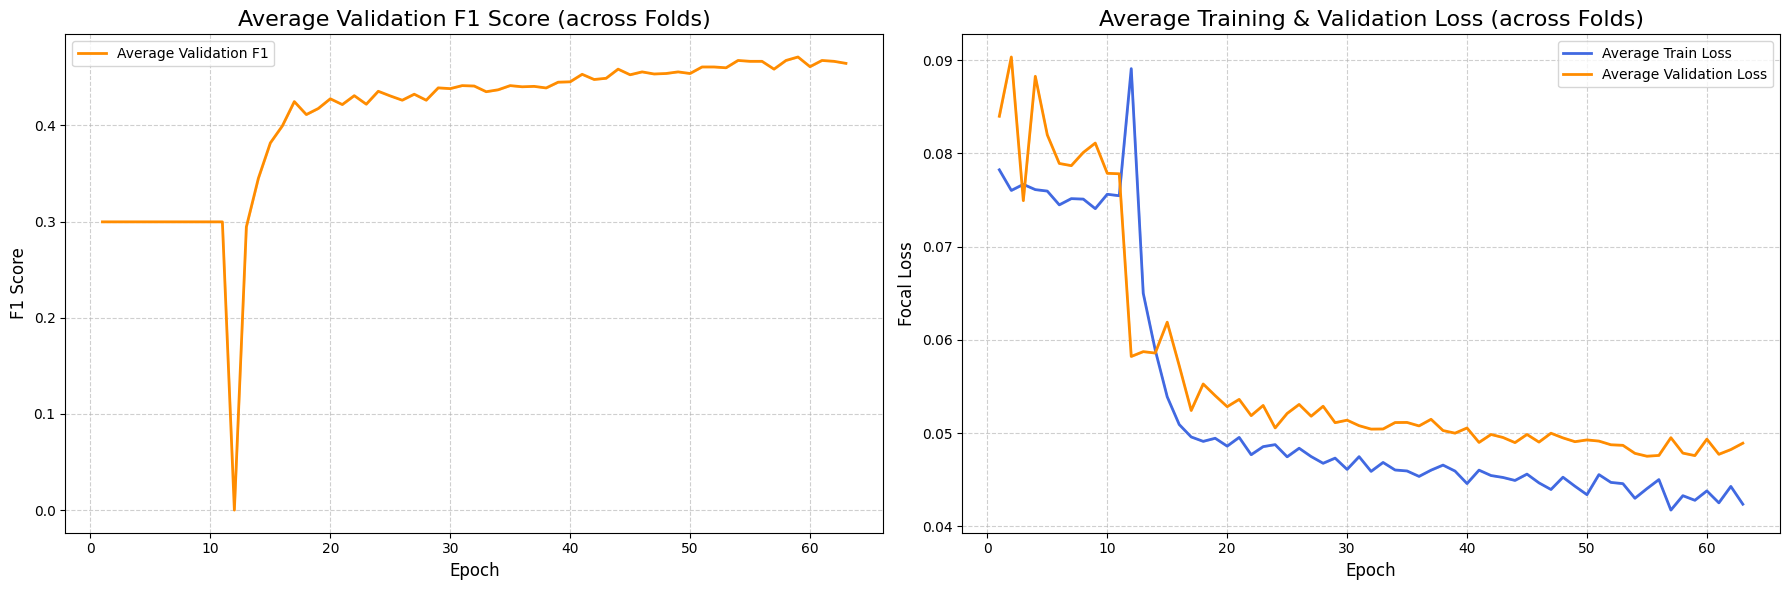

In [41]:
#       VISUALIZE TRAINING HISTORY 
# Plotting the AVERAGE learning curves across all K folds)
import matplotlib.pyplot as plt
import numpy as np

def plot_average_history(histories):
    """
    Plots the average training and validation loss and F1 scores across all folds.
    """
    print("\n--- Plotting average training history across all folds ---")
    
    if not histories:
        print("History object list is empty. Skipping plotting.")
        return

    # Create a figure with two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Calculate average and std dev for each metric
    min_epochs = min([len(h['val_loss']) for h in histories])
    val_f1_scores = np.array([h['val_f1_score'][:min_epochs] for h in histories])
    
    val_loss_scores = np.array([h['val_loss'][:min_epochs] for h in histories])
    train_loss_scores = np.array([h['loss'][:min_epochs] for h in histories])

    # Calculate the mean and standard deviation across the folds for each epoch.
    mean_val_f1 = np.mean(val_f1_scores, axis=0)
    std_val_f1 = np.std(val_f1_scores, axis=0)
    
    mean_val_loss = np.mean(val_loss_scores, axis=0)
    std_val_loss = np.std(val_loss_scores, axis=0)
    
    mean_train_loss = np.mean(train_loss_scores, axis=0)
    std_train_loss = np.std(train_loss_scores, axis=0)
    
    epochs = range(1, min_epochs + 1)

    # Plot 1: Average Validation F1 Score 
    ax1.plot(epochs, mean_val_f1, label='Average Validation F1', color='darkorange', lw=2)
    # Add a shaded region for the standard deviation.
    ax1.fill_between(epochs, mean_val_f1 - std_val_f1, mean_val_f1 + std_val_f1, color='darkorange', alpha=0.2)
    ax1.set_title('Average Validation F1 Score (across Folds)', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    #  Plot 2: Average Training & Validation Loss 
    ax2.plot(epochs, mean_train_loss, label='Average Train Loss', color='royalblue', lw=2)
    ax2.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='royalblue', alpha=0.2)
    
    ax2.plot(epochs, mean_val_loss, label='Average Validation Loss', color='darkorange', lw=2)
    ax2.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='darkorange', alpha=0.2)

    ax2.set_title('Average Training & Validation Loss (across Folds)', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Focal Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call the new plotting function with our list of histories.
plot_average_history(oof_histories)

# 15. Classification Report

## 5.3 Performance Analysis using Classification Report

- While the learning curves give us a view of the training process, this cell performs the definitive **quantitative evaluation** of our best-performing model. <br>
- The process is as follows:
1.  **Load Best ModelS:** These were saved weights for each fold in the cross-validation that achieved the highest F1 score during training.
2.  **Predict on Validation Data:** These models are used to make predictions on the validation set.
3.  **Optimize Decision Threshold:** For an imbalanced dataset, a standard threshold is rarely optimal. Thus the **best possible threshold** is determined by evaluating the F1 score across a range of values (0.1 to 0.9). This is a fine-tuning step that directly maximizes our success metric.
4.  **Generate Classification Report:** Finally, using the optimal threshold, we generate a report that provides a breakdown of the model's performance.
   
- This report is the tool for judging whether the model has met the first business objectives 

In [42]:
# CLASSIFICATION METRIC
from sklearn.metrics import classification_report, f1_score
import numpy as np

print("--- Starting Detailed Model Evaluation ---")

# Define the model weights path and validation dataset to use
print("Mode: Single 80/20 Split. Evaluating the single trained model.")
model_weights_path = "best_model_single_split.weights.h5"
val_ds_for_eval = val_dataset # Use the dataset object directly

# Extract the true labels for the classification report
# We iterate through the dataset to get all the true labels.
print("Extracting true labels from the validation dataset...")
y_val_true = np.concatenate([y for x, y in val_ds_for_eval], axis=0)
print(f"Validation data and {len(y_val_true)} true labels are ready.")

# Build a fresh model instance and load the best weights 
print(f"Loading best model weights from: {model_weights_path}")
with strategy.scope():
    evaluation_model = build_and_compile_model() 
    evaluation_model.load_weights(model_weights_path)
print("Best weights loaded successfully into new model instance.")

# Get Predictions on the validation set 
print("\n--- Getting predictions... ---")
val_pred_proba = evaluation_model.predict(val_ds_for_eval)

# Search for the Best Decision Threshold 
print("\n--- Searching for the optimal decision threshold... ---")
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_val_pred_binary = (val_pred_proba > threshold).astype(int)
    current_f1 = f1_score(y_val_true, y_val_pred_binary)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"Optimal threshold found: {best_threshold:.2f}")
print(f"Best F1 Score on this validation set: {best_f1:.4f}")

# Display a Full Classification Report 
print(f"\n--- Classification Report (using optimal threshold of {best_threshold:.2f}) ---\n")
y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)
print(classification_report(y_val_true, y_val_pred_optimal, target_names=['No Landslide (0)', 'Landslide (1)']))

--- Starting Detailed Model Evaluation ---
Mode: Single 80/20 Split. Evaluating the single trained model.
Extracting true labels from the validation dataset...
Validation data and 715 true labels are ready.
Loading best model weights from: best_model_single_split.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
Best weights loaded successfully into new model instance.

--- Getting predictions... ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 908ms/step

--- Searching for the optimal decision threshold... ---
Optimal threshold found: 0.65
Best F1 Score on this validation set: 0.6113

--- Classification Report (using optimal threshold of 0.65) ---

                  precision    recall  f1-score   support

No Landslide (0)       0.92      0.90      0.91       589
   Landslide (1)       0.58      0.64      0.61       126

        accuracy                           0.86       715
       macro avg       0.75      0.77      0.76       715
    weighted avg       0.86      0

# Load Best Model and Evaluate on Validation Set
This cell performs the definitive evaluation of our best model on the data it didn't train on. It answers the question: "How well did our model truly perform?"

# 16. Create the Test Dataset
First, we need to create a tf.data.Dataset for our test images. We will use our powerful build_dataset functioN.

# 6. **Deployment**

## 6.1 Prepare the Test Dataset

- This cell defines a new set of `get_parse_test_function`and `build_test_dataset` functions for the test set. This pipeline is almost identical to the one for validation data, with the key difference being it does not parse or expect a label, as none exists for the test data. <br>
- Operations perfromed:
1.  **Parse & Decode:** Reads the raw test data from the `test.tfrecord` file.
2.  **Engineer Features:** Applies the exact same feature engineering function (`engineer_features`) using the same global statistics that were calculated from the training set to ensure the model sees the test data in the same format it was trained on.
3.  **Scale & Resize:** Performs the identical scaling and resizing operations.

- Finally, it constructs the `test_dataset` object, batching the data and using `.prefetch()` to ensure an efficient prediction process.

In [43]:
# CREATE THE TEST DATASET

def get_parse_test_function(p01_vec, p99_vec):
    """
    This is a factory that creates our TEST data parsing function. 
    It "closes over" the percentile vectors, making them available for robust scaling.
    """
    # Convert the stats vectors to TensorFlow constants
    min_clip_tensor = tf.constant(p01_vec, dtype=tf.float32)
    max_clip_tensor = tf.constant(p99_vec, dtype=tf.float32)
    range_tensor = max_clip_tensor - min_clip_tensor
    epsilon = tf.keras.backend.epsilon()

    @tf.function
    def parse_test_tfrecord_function(example_proto):
        """
        Parses a single tf.train.Example proto for TEST data.
        """
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
        }
        
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        # Decode and Reshape the Base Image 
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # Call the feature engineering function to get the 15-channel raw tensor
        image_with_features = engineer_features(image)
        
        # --- Apply the SAME Per-Channel Robust Scaling ---
        # Step 1: Clip the data to the robust 1st and 99th percentile boundaries
        clipped_image = tf.clip_by_value(image_with_features, min_clip_tensor, max_clip_tensor)
        
        # Step 2: Scale the clipped data to a 0-1 range
        normalized_image = (clipped_image - min_clip_tensor) / (range_tensor + epsilon)
        
        # Resize and ensure the final shape
        image_resized = tf.image.resize(normalized_image, Config.TARGET_SIZE, method='bilinear')
        final_image = tf.ensure_shape(image_resized, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        image_id = parsed_features['id']
        
        return final_image, image_id

    return parse_test_tfrecord_function

# --- Second, define the build function for the test dataset ---
def build_test_dataset(tfrecord_path, p01_vec, p99_vec):
    """
    Builds a high-performance tf.data.Dataset for inference.
    It now requires the global percentile vectors to create the correct parser.
    """
    # Create the specific parsing function for this dataset
    parse_fn = get_parse_test_function(p01_vec, p99_vec)
    
    dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Execute the build process ---
print("--- Building final test dataset for inference (with per-channel Robust Scaling)... ---\n")
# Check for the new global statistics variables
if 'global_p01_vec' in locals() and 'global_p99_vec' in locals():
    test_dataset = build_test_dataset(TEST_TFRECORD_PATH, global_p01_vec, global_p99_vec)
    print("--- Test dataset built successfully. ---")
    
    # Sanity check to confirm the output shapes
    print("\n--- Inspecting a batch from the test dataset... ---")
    for images, ids in test_dataset.take(1):
        print("Image batch shape:", images.shape)
        print("ID batch shape:", ids.shape)
else:
    print("ERROR: `global_p01_vec` or `global_p99_vec` not found. Please run the cell that calculates global statistics first.")

--- Building final test dataset for inference (with per-channel Robust Scaling)... ---

--- Test dataset built successfully. ---

--- Inspecting a batch from the test dataset... ---
Image batch shape: (128, 224, 224, 15)
ID batch shape: (128,)


In [ ]:
# # CREATE THE TEST DATASET

# def get_parse_test_function(stats):
#     """
#     This is a factory that creates our TEST data parsing function. 
#     It "closes over" the stats dictionary, making it available for normalization.
#     """
#     # Convert the stats dictionary to a TensorFlow constant
#     stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}
#     @tf.function
#     def parse_test_tfrecord_function(example_proto):
#         """
#         Parses a single tf.train.Example proto for TEST data.
#         """
#         feature_description = {
#             'image': tf.io.FixedLenFeature([], tf.string),
#             'id': tf.io.FixedLenFeature([], tf.string),
#         }
        
#         parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
#         # Decode and Reshape the Base Image 
#         image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
#         image = tf.cast(image, tf.float32)
#         image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
#         # Call the feature engineering function, which now returns ONE tensor
#         image_with_features = engineer_features(image, stats_tensor)
        
#         # Standard Preprocessing on the final combined tensor
#         image_resized = tf.image.resize(image_with_features, Config.TARGET_SIZE, method='bilinear')
#         image_scaled = image_resized / 255.0
        
#         final_image = tf.ensure_shape(image_scaled, [*Config.TARGET_SIZE, Config.N_CHANNELS])
#         image_id = parsed_features['id']
        
#         return final_image, image_id

#     return parse_test_tfrecord_function

# # --- Second, define the build function for the test dataset ---
# def build_test_dataset(tfrecord_path, stats):
#     """
#     Builds a high-performance tf.data.Dataset for inference.
#     It now requires the global_stats to create the correct parser.
#     """
#     # Create the specific parsing function for this dataset
#     parse_fn = get_parse_test_function(stats)
    
#     dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
#     dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=False)
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
#     return dataset

# # --- Execute the build process ---
# print("--- Building final test dataset for inference (with unified feature engineering)... ---\n")
# # The global_stats dictionary should be available from a previous cell
# if 'global_stats' in locals():
#     test_dataset = build_test_dataset(TEST_TFRECORD_PATH, global_stats)
#     print("--- Test dataset built successfully. ---")
    
#     # Sanity check to confirm the output shapes
#     print("\n--- Inspecting a batch from the test dataset... ---")
#     for images, ids in test_dataset.take(1):
#         print("Image batch shape:", images.shape)
#         print("ID batch shape:", ids.shape)
# else:
#     print("ERROR: `global_stats` dictionary not found. Please run the cell that calculates global statistics first.")

# 17. Ensemble Predictions and Create Submission File
Runs the final inference, formats the output, and saves the file 

1. Iterative Loading: It loops from 1 to 5, loading the weights from each of your saved "expert" models (model_fold_1.weights.h5, model_fold_2.weights.h5, etc.).

2. Prediction Gathering: It gets a separate set of predictions on the test data from each of the 5 models.

3. Ensembling: It takes the average of these 5 sets of predictions. This final ensembled_predictions array is more robust and less prone to individual model errors than any single prediction would be.

4. Submission: It creates the submission.csv using these final, averaged probabilities, ensuring compliance with the competition rules.

## 6.2 Generate Final Predictions with Test-Time Augmentation (TTA)

- To maximize the accuracy of our final output, a technique called **Test-Time Augmentation (TTA)** is employed. <br>
- The TTA process involves:
1.  **Original Prediction:** We first generate a baseline set of predictions on the original, unaltered test images.
2.  **Augmented Predictions:** We then create two augmented versions of the test dataset: one with a horizontal flip and another with a vertical flip. We generate a new set of predictions for each of these augmented versions.
3.  **Ensemble Averaging:** Finally, we **average the prediction probabilities** from all three views (original, horizontal flip, vertical flip) for each test image. This ensembling technique often leads to more stable and accurate final predictions by reducing the impact of any random artifacts in the test images.

- Finally a `submission.csv` files is created using the optimal threshold we discovered during our evaluation phase.

In [44]:
# 17. PREDICT WITH TTA AND CREATE MULTIPLE SUBMISSION FILES

print("--- Starting prediction with Test Time Augmentation (TTA) ---")

# --- 1. Load your best trained model ---
# This assumes you are running this after a single 80/20 training run
model_weights_path = "best_model_single_split.weights.h5" 
print(f"Loading model weights from: {model_weights_path}")

with strategy.scope():
    # Re-build the model architecture exactly as it was during training
    prediction_model = build_and_compile_model()
    prediction_model.load_weights(model_weights_path)

print("Model loaded successfully.")

# --- 2. Create the clean test dataset for TTA ---
print("Building a clean, non-augmented test dataset for TTA...")
# --- FIX: Pass the correct global_p01_vec and global_p99_vec variables ---
test_dataset_tta = build_test_dataset(TEST_TFRECORD_PATH, global_p01_vec, global_p99_vec)

# --- 3. Perform TTA Predictions ---
print("Generating TTA predictions (this may take a moment)...")

# Original predictions
original_preds = prediction_model.predict(test_dataset_tta, verbose=1)

# Horizontal Flip predictions
tta_hflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_left_right(img), id))
hflip_preds = prediction_model.predict(tta_hflip, verbose=1)

# Vertical Flip predictions
tta_vflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_up_down(img), id))
vflip_preds = prediction_model.predict(tta_vflip, verbose=1)

# --- 4. Average the predictions ---
# Averaging the probabilities from 3 different "views" of each image
final_predictions = (original_preds + hflip_preds + vflip_preds) / 3.0
print("...TTA predictions averaged successfully.")

# --- 5. Create and Save Submission Files with a Loop ---
print("\n--- Creating final submission files for different thresholds... ---")

# Define the thresholds you want to test
# --- FIX: Add a safety check for best_threshold ---
if 'best_threshold' not in locals():
    print("Warning: 'best_threshold' not found from evaluation. Using 0.5 as the tuned threshold.")
    best_threshold = 0.5
    
thresholds_to_submit = {
    "tuned_threshold": best_threshold, # The optimal one from your validation set
    "standard_threshold": 0.5         # The standard baseline
}

for name, threshold_value in thresholds_to_submit.items():
    print(f"\nProcessing submission for: '{name}' with threshold = {threshold_value:.4f}")
    
    # Create the DataFrame
    submission_df = pd.DataFrame({
        'ID': test_df['ID'].values,
        'Target': (final_predictions.flatten() > threshold_value).astype(int)
    })

    # Define the filepath
    submission_filepath = f"submission_tta_{name}.csv"
    
    # Save the file
    submission_df.to_csv(submission_filepath, index=False)

    print(f"-> Submission file created: {submission_filepath}")
    print("File head:")
    print(submission_df.head())

print("\n--- All submission files created successfully! ---")

--- Starting prediction with Test Time Augmentation (TTA) ---
Loading model weights from: best_model_single_split.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
Model loaded successfully.
Building a clean, non-augmented test dataset for TTA...
Generating TTA predictions (this may take a moment)...
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 835ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 824ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 707ms/step
...TTA predictions averaged successfully.

--- Creating final submission files for different thresholds... ---

Processing submission for: 'tuned_threshold' with threshold = 0.6500
-> Submission file created: submission_tta_tuned_threshold.csv
File head:
          ID  Target
0  ID_ICB8K9       0
1  ID_2D4AOJ       0
2  ID_2TVPI0       0
3  ID_E05WIK       0
4  ID_KKFDJO       1

Processing submission for: 'standard_threshold' with threshold = 0.5000
-> Submission file created: submission_tta_standard_threshold.csv
File head:
        

In [ ]:

# # 17. PREDICT WITH TTA AND CREATE MULTIPLE SUBMISSION FILES

# print("--- Starting prediction with Test Time Augmentation (TTA) ---")

# # --- 1. Load your best trained model ---
# # This assumes you are running this after a single 80/20 training run
# model_weights_path = "best_model_single_split.weights.h5" 
# print(f"Loading model weights from: {model_weights_path}")

# with strategy.scope():
#     # Re-build the model architecture exactly as it was during training
#     prediction_model = build_and_compile_model()
#     prediction_model.load_weights(model_weights_path)

# print("Model loaded successfully.")

# # --- 2. Create the clean test dataset for TTA ---
# print("Building a clean, non-augmented test dataset for TTA...")
# test_dataset_tta = build_test_dataset(TEST_TFRECORD_PATH, global_stats)

# # --- 3. Perform TTA Predictions ---
# print("Generating TTA predictions (this may take a moment)...")

# # Original predictions
# original_preds = prediction_model.predict(test_dataset_tta, verbose=1)

# # Horizontal Flip predictions
# tta_hflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_left_right(img), id))
# hflip_preds = prediction_model.predict(tta_hflip, verbose=1)

# # Vertical Flip predictions
# tta_vflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_up_down(img), id))
# vflip_preds = prediction_model.predict(tta_vflip, verbose=1)

# # --- 4. Average the predictions ---
# # Averaging the probabilities from 3 different "views" of each image
# final_predictions = (original_preds + hflip_preds + vflip_preds) / 3.0
# print("...TTA predictions averaged successfully.")

# # --- 5. Create and Save Submission Files with a Loop ---
# print("\n--- Creating final submission files for different thresholds... ---")

# # Define the thresholds you want to test
# thresholds_to_submit = {
#     "tuned_threshold": best_threshold, # The optimal one from your validation set
#     "standard_threshold": 0.5         # The standard baseline
# }

# for name, threshold_value in thresholds_to_submit.items():
#     print(f"\nProcessing submission for: '{name}' with threshold = {threshold_value:.4f}")
    
#     # Create the DataFrame
#     submission_df = pd.DataFrame({
#         'ID': test_df['ID'].values,
#         'Target': (final_predictions.flatten() > threshold_value).astype(int)
#     })

#     # Define the filepath
#     submission_filepath = f"submission_tta_{name}.csv"
    
#     # Save the file
#     submission_df.to_csv(submission_filepath, index=False)

#     print(f"-> Submission file created: {submission_filepath}")
#     print("File head:")
#     print(submission_df.head())

# print("\n--- All submission files created successfully! ---") 

In [ ]:
# # higher augm

# # 17. PREDICT WITH ADVANCED TTA (FLIPS + ROTATIONS) AND CREATE SUBMISSIONS

# print("--- Starting prediction with Advanced Test Time Augmentation (8 views)... ---")

# # --- 1. Load your best trained model ---
# model_weights_path = "best_model_single_split.weights.h5" 
# print(f"Loading model weights from: {model_weights_path}")

# with strategy.scope():
#     prediction_model = build_and_compile_model()
#     prediction_model.load_weights(model_weights_path)

# print("Model loaded successfully.")

# # --- 2. Create the clean test dataset ---
# print("Building a clean, non-augmented test dataset for TTA...")
# test_dataset_tta = build_test_dataset(TEST_TFRECORD_PATH, global_stats)

# # --- 3. Perform TTA Predictions ---
# print("Generating TTA predictions (this will take longer)...")

# # We will store all predictions in a list and average at the end
# all_tta_predictions = []

# # View 1: Original
# print("Predicting on original images (1/8)...")
# original_preds = prediction_model.predict(test_dataset_tta, verbose=1)
# all_tta_predictions.append(original_preds)

# # View 2: Horizontal Flip
# print("Predicting on H-Flipped images (2/8)...")
# tta_hflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_left_right(img), id))
# hflip_preds = prediction_model.predict(tta_hflip, verbose=1)
# all_tta_predictions.append(hflip_preds)

# # --- Add Rotations ---
# # TensorFlow's rot90 takes an integer `k` where k*90 degrees is the rotation

# # View 3: Rotated 90 degrees
# print("Predicting on Rotated 90 images (3/8)...")
# tta_rot90 = test_dataset_tta.map(lambda img, id: (tf.image.rot90(img, k=1), id))
# rot90_preds = prediction_model.predict(tta_rot90, verbose=1)
# all_tta_predictions.append(rot90_preds)

# # View 4: Rotated 90 degrees + H-Flip
# print("Predicting on Rotated 90 + H-Flipped images (4/8)...")
# tta_rot90_hflip = tta_rot90.map(lambda img, id: (tf.image.flip_left_right(img), id))
# rot90_hflip_preds = prediction_model.predict(tta_rot90_hflip, verbose=1)
# all_tta_predictions.append(rot90_hflip_preds)

# # View 5: Rotated 180 degrees
# print("Predicting on Rotated 180 images (5/8)...")
# tta_rot180 = test_dataset_tta.map(lambda img, id: (tf.image.rot90(img, k=2), id))
# rot180_preds = prediction_model.predict(tta_rot180, verbose=1)
# all_tta_predictions.append(rot180_preds)

# # View 6: Rotated 180 degrees + H-Flip
# print("Predicting on Rotated 180 + H-Flipped images (6/8)...")
# tta_rot180_hflip = tta_rot180.map(lambda img, id: (tf.image.flip_left_right(img), id))
# rot180_hflip_preds = prediction_model.predict(tta_rot180_hflip, verbose=1)
# all_tta_predictions.append(rot180_hflip_preds)

# # View 7: Rotated 270 degrees
# print("Predicting on Rotated 270 images (7/8)...")
# tta_rot270 = test_dataset_tta.map(lambda img, id: (tf.image.rot90(img, k=3), id))
# rot270_preds = prediction_model.predict(tta_rot270, verbose=1)
# all_tta_predictions.append(rot270_preds)

# # View 8: Rotated 270 degrees + H-Flip
# print("Predicting on Rotated 270 + H-Flipped images (8/8)...")
# tta_rot270_hflip = tta_rot270.map(lambda img, id: (tf.image.flip_left_right(img), id))
# rot270_hflip_preds = prediction_model.predict(tta_rot270_hflip, verbose=1)
# all_tta_predictions.append(rot270_hflip_preds)

# # --- 4. Average all 8 sets of predictions ---
# final_predictions = np.mean(all_tta_predictions, axis=0)
# print("\n...All 8 TTA predictions averaged successfully.")

# # --- 5. Create and Save Submission Files ---
# print("\n--- Creating final submission files for different thresholds... ---")

# thresholds_to_submit = {
#     "tuned_threshold": best_threshold,
#     "standard_threshold": 0.5
# }

# for name, threshold_value in thresholds_to_submit.items():
#     print(f"\nProcessing submission for: '{name}' with threshold = {threshold_value:.4f}")
#     submission_df = pd.DataFrame({
#         'ID': test_df['ID'].values,
#         'Target': (final_predictions.flatten() > threshold_value).astype(int)
#     })
#     submission_filepath = f"submission_advanced_tta_{name}.csv"
#     submission_df.to_csv(submission_filepath, index=False)
#     print(f"-> Submission file created: {submission_filepath}")
#     print(submission_df.head())

# print("\n--- All submission files created successfully! ---")